In [1]:
%matplotlib inline
import bioread
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
import os

In [2]:
class Segment(object):
    def __init__(self, name, start_index_text, start_index, seg_before):
        self.name = name
        self.start_index_text = start_index_text
        self.start_index = start_index
        self.end_index_text = ""
        self.end_index = 0
        self.before = seg_before
        self.after = None
        self.marker_inside_text = ""
        self.marker_inside_index = 0

    def make_df(self, file):
        data = {}
        for channel in file.named_channels:
            signal = np.array(file.named_channels[channel].data[self.start_index:self.end_index])
            data[channel] = signal
        self.df = pd.DataFrame(data)
        print('Dataframe of {0}:'.format(self.name))
        #print(self.df)


In [3]:
class Filedata(object):
    def __init__(self, filename):
        self.filename = filename
        self.segments = {}

    def preparedata(self):
        name_seg_before = None
        name_seg_after = None
        file = bioread.read_file('../RAW_data/labeled/{0}.acq'.format(self.filename))
        for m in file.event_markers:
            if m.text == 'post nf1_VR (crashed)' and self.filename == 'PB1_only_part2':
                continue

            if m.text == 'recording interrupted' and self.filename == 'PB12':
                m.text = 'stress2_MIST_end'

            if m.text == 'stress1_ABBA_start' and m.sample_index == 946410 and self.filename == 'PB13':
                m.text = "stress1_ABBA_end"

            if m.text == 'stress2_MIST_end' and self.filename == 'PB23':
                m.text = "stress1_MIST_end"

            if m.text == '' and self.filename == 'PB27':
                m.text = "nf2_VR_start"

            if m.text == '' and self.filename == 'PB15':
                m.text = "nf2_VR_end"

            if m.text == '' and self.filename in ['PB4', 'PB16', 'PB22', 'PB25', 'PB12-partie_2']:
                continue

            if m.text == 'baseline':
                name = m.text
                current_seg = Segment(name, m.text, m.sample_index, name_seg_before)
                self.segments[name] = current_seg
                name_seg_before = name
            elif m.text.startswith("Segment "):
                continue
            elif m.text.endswith("_start"):
                name = m.text.removesuffix("_start")
                current_seg = Segment(name, m.text, m.sample_index, name_seg_before)
                self.segments[name] = current_seg
                if name_seg_before != None:
                    self.segments[name_seg_before].after = name
                name_seg_before = name
            elif m.text.endswith("_end"):
                name = m.text.removesuffix("_end")
                current_seg = self.segments[name]
                current_seg.end_index_text = m.text
                current_seg.end_index = m.sample_index
                current_seg.make_df(file)
                name_seg_before = name
            elif m.text.endswith("_unlimited"):
                if name_seg_before != None:
                    print("unlimited: " + m.text)
                    self.segments[name_seg_before].marker_inside_text = m.text
                    self.segments[name_seg_before].marker_inside_index = m.sample_index
            else:
                print("unknown: " + m.text)
            print(m.text)

        if self.filename in ['PB4', 'PB7', 'PB12', 'PB13', 'PB14', 'PB15', 'PB16', 'PB17', 'PB21', 'PB25']:
            current_seg = self.segments['baseline']
            current_seg.end_index_text = self.segments['stress1_ABBA'].start_index_text
            current_seg.end_index = self.segments['stress1_ABBA'].start_index
            current_seg.make_df(file)

        if self.filename in ['PB2', 'PB3', 'PB5', 'PB19', 'PB22', 'PB23', 'PB24', 'PB26', 'PB27']:
            current_seg = self.segments['baseline']
            current_seg.end_index_text = self.segments['stress1_MIST'].start_index_text
            current_seg.end_index = self.segments['stress1_MIST'].start_index
            current_seg.make_df(file)

        if self.filename in ['PB12-partie_2']:
            current_seg = self.segments['baseline']
            current_seg.end_index_text = self.segments['stress2_MIST'].start_index_text
            current_seg.end_index = self.segments['stress2_MIST'].start_index
            current_seg.make_df(file)
   

In [4]:
def ECG_report(df, name, fnam):
    print('Segment {0}.{1}:'.format(fnam, name))
    nk.signal_plot(df, subplots=True, sampling_rate=1000)
    #fig = plt.gcf()
    #fig.savefig("all_{0}.png".format(name))
    plt.show()
    plt.close()

    print('ECG of segment {0}.{1}:'.format(fnam, name))
    nk.signal_plot(df['ECG (.5 - 35 Hz)'], sampling_rate=1000)
    plt.grid(True)
    plt.xlim(0, 10)
    plt.ylim(-0.5,0.5)
    #fig = plt.gcf()
    #fig.savefig("ecg_{0}.png".format(name))
    plt.show()
    plt.close()
    # Find peaks
    peaks, info = nk.ecg_peaks(df['ECG (.5 - 35 Hz)'], sampling_rate=1000)
    # Compute HRV indices
    hrv = nk.hrv_time(peaks, sampling_rate=1000, show=True)
    plt.title('ECG Peaks of {0}.{1}:'.format(fnam, name))
    plt.grid(True)
    #fig = plt.gcf()
    #fig.savefig("hrv_{0}_{1}.png".format(fnam, name))
    plt.show()
    plt.close()
    print('HRV of segment {0}.{1}:'.format(fnam, name))
    print(hrv)
    #for col in hrv:
    #    print(col)
    print(hrv['HRV_MeanNN'])
    #print(hrv.iloc[0]['HRV_MeanNN'])
    print(hrv['HRV_SDNN'])
    #print(hrv.iloc[0]['HRV_SDNN'])
    print(hrv['HRV_RMSSD'])
    #print(hrv.iloc[0]['HRV_RMSSD'])

    # Preprocess ECG signal
    signals, info = nk.ecg_process(df['ECG (.5 - 35 Hz)'], sampling_rate=1000)
    # Visualize
    nk.ecg_plot(signals, info)
    #fig = plt.gcf()
    #fig.savefig("ecg_proccess_{0}_{1}.png".format(fnam, name))
    plt.show()
    plt.close()
    # Analyze
    analyze_df = nk.ecg_analyze(signals, sampling_rate=1000)
    print('ECG analyze output of segment {0}.{1}:'.format(fnam, name))
    print(analyze_df)
    #for col in analyze_df:
    #    print(col)
    print(analyze_df['HRV_MeanNN'].apply(lambda x: np.array(x).flatten()[0]))
    #print(analyze_df['HRV_MeanNN'].iloc[0][0][0])
    print(analyze_df['HRV_SDNN'].apply(lambda x: np.array(x).flatten()[0]))
    #print(analyze_df.iloc[0]['HRV_SDNN'][0][0])
    print(analyze_df['HRV_RMSSD'].apply(lambda x: np.array(x).flatten()[0]))
    #print(analyze_df.iloc[0]['HRV_RMSSD'][0][0])


In [5]:
def EDA_report(df, name, fnam):
    #reportname = 'EDAreport_{0}.html'.format(name)
    #signals, info = nk.eda_process(df['EDA (0 - 35 Hz)'], sampling_rate=1000, report=reportname)
    #signals, info = nk.eda_process(df['EDA (0 - 35 Hz)'], sampling_rate=1000, report="text")
    signals, info = nk.eda_process(df['EDA (0 - 35 Hz)'], sampling_rate=1000)
    nk.eda_plot(signals, info)
    plt.grid(True)
    #fig = plt.gcf()
    #fig.savefig("eda_{0}_{1}.png".format(fnam, name))
    plt.show()
    plt.close()
    print('EDA of segment {0}.{1}:'.format(fnam, name))
    #print(signals)
    #print(info)
    analyze_df = nk.eda_analyze(signals, sampling_rate=1000)
    print(analyze_df)



In [6]:
def sort_filelist(l):
    import re
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum = lambda key: [convert(c) for c in re.split(r'PB(\d+)', key)]
    l.sort(key=alphanum)
    return l

In [7]:
def main():
    fdatas = {}
    labeled_files = os.listdir('../RAW_data/labeled')
    for lbfile in sort_filelist(labeled_files):
        if lbfile.endswith(".acq"):
           filename = lbfile.removesuffix(".acq")
           print(filename)
           fdata = Filedata(filename)
           fdata.preparedata()
           fdatas[filename] = fdata

    for fnam, fdat in fdatas.items():
        print('\nFile {0}:'.format(fnam))
        for name, seg in fdat.segments.items():
            ECG_report(seg.df, name, fnam)
            EDA_report(seg.df, name, fnam)
            #pass

        print('\nFor file {0}:'.format(fnam))
        for name, seg in fdat.segments.items():
            if seg.marker_inside_index != 0:
                print(seg.marker_inside_index)
                print('segment: [{0}] before: [{1}] after [{2}] start [{3}] end [{4}] marker_inside label[{5}] marker_inside index [{6}]'.format(name, seg.before, seg.after, seg.start_index, seg.end_index, seg.marker_inside_text, seg.marker_inside_index))
            else:
                print('segment: [{0}] before: [{1}] after [{2}] start [{3}] end [{4}]'.format(name, seg.before, seg.after, seg.start_index, seg.end_index))
        #first = ""
        #for name, seg in segments.items():
        #    if seg.before == None:
        #        first = name
        #        break
        #seg = segments[first]
        #while True:
        #    print(seg.name)
        #    if seg.after == None:
        #        break
        #    seg = segments[seg.after]
        #In Python 3.6+ dictionaries preserve insertion order.
        #sys.exit(0)
    return 0

PB1 (only part2)
unknown: post nf1_VR (crashed)
post nf1_VR (crashed)
stress2_ABBA_start
Dataframe of stress2_ABBA:
stress2_ABBA_end
nf2_2D_start
unlimited: nf2_2D_unlimited
nf2_2D_unlimited
Dataframe of nf2_2D:
nf2_2D_end
PB2
baseline
stress1_MIST_start
Dataframe of stress1_MIST:
stress1_MIST_end
unknown: 

nf1_VR_start
unlimited: nf1_VR_unlimited
nf1_VR_unlimited
Dataframe of nf1_VR:
nf1_VR_end
stress2_ABBA_start
Dataframe of stress2_ABBA:
stress2_ABBA_end
nf2_2D_start
unlimited: nf2_2D_unlimited
nf2_2D_unlimited
Dataframe of nf2_2D:
nf2_2D_end
Dataframe of baseline:
PB3
baseline
stress1_MIST_start
Dataframe of stress1_MIST:
stress1_MIST_end
nf1_2D_start
unlimited: nf1_2D_unlimited
nf1_2D_unlimited
Dataframe of nf1_2D:
nf1_2D_end
stress2_ABBA_start
Dataframe of stress2_ABBA:
stress2_ABBA_end
nf2_VR_start
unlimited: nf2_VR_unlimited
nf2_VR_unlimited
Dataframe of nf2_VR:
nf2_VR_end
Dataframe of baseline:
PB4
baseline
stress1_ABBA_start
Dataframe of stress1_ABBA:
stress1_ABBA_end
nf1_2D

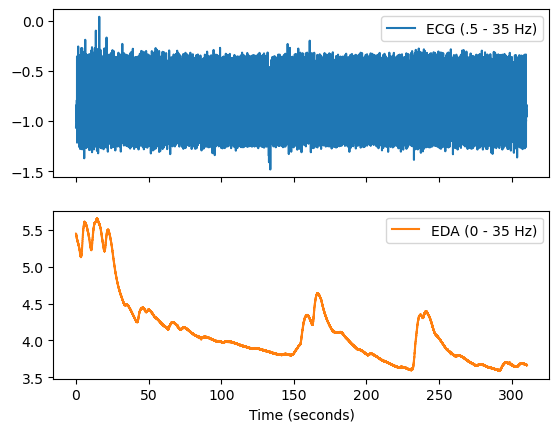

ECG of segment PB1 (only part2).stress2_ABBA:


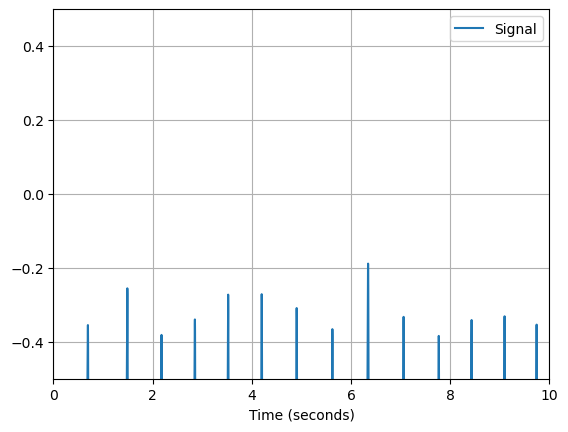

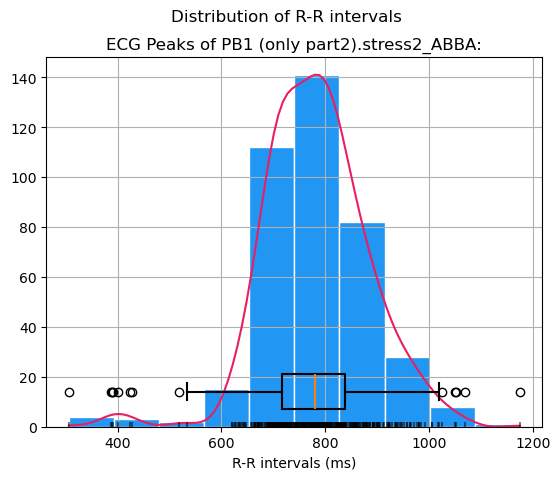

HRV of segment PB1 (only part2).stress2_ABBA:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  781.828283  105.784475   27.763008  102.618978   26.699003   103.86276   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN  100.187482  100.312086  ...      122.0   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     1.055865        706.0        859.0  40.656566  68.939394      306.0   

   HRV_MaxNN  HRV_HTI  HRV_TINN  
0     1175.0     22.0   421.875  

[1 rows x 25 columns]
0    781.828283
Name: HRV_MeanNN, dtype: float64
0    105.784475
Name: HRV_SDNN, dtype: float64
0    100.187482
Name: HRV_RMSSD, dtype: float64


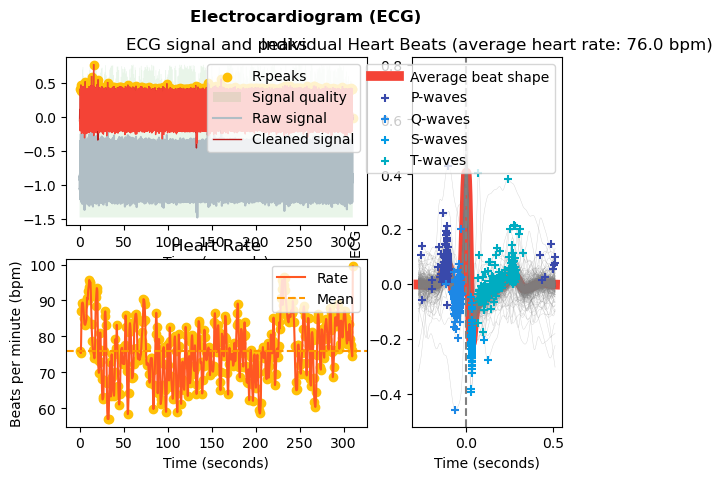

ECG analyze output of segment PB1 (only part2).stress2_ABBA:
  ECG_Rate_Mean             HRV_MeanNN               HRV_SDNN  \
0     75.973187  [[790.0255102040817]]  [[87.99944409406429]]   

               HRV_SDANN1             HRV_SDNNI1              HRV_SDANN2  \
0  [[19.978724750815548]]  [[85.87451326721899]]  [[20.445021802731397]]   

             HRV_SDNNI2 HRV_SDANN5 HRV_SDNNI5              HRV_RMSSD  ...  \
0  [[83.8894571346283]]    [[nan]]    [[nan]]  [[67.01690819975755]]  ...   

               HRV_SampEn             HRV_ShanEn             HRV_FuzzyEn  \
0  [[1.4678743481123135]]  [[7.653112340351856]]  [[1.1585246398873912]]   

                 HRV_MSEn               HRV_CMSEn              HRV_RCMSEn  \
0  [[1.3781320132376251]]  [[1.3955982405237763]]  [[2.1243666379767245]]   

                  HRV_CD                HRV_HFD                HRV_KFD  \
0  [[1.737726421566056]]  [[1.833581467202542]]  [[3.673272020460387]]   

                  HRV_LZC  
0  [[0.87905202

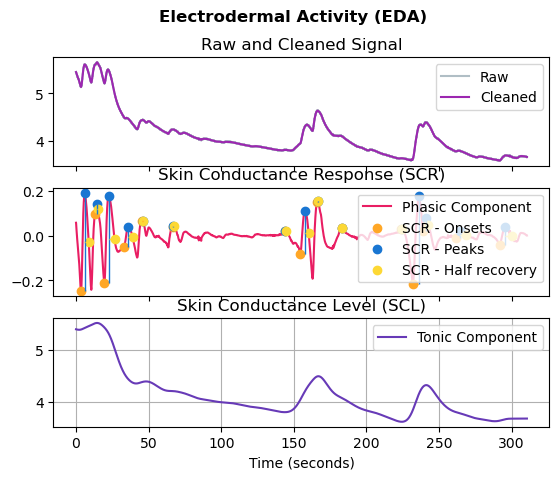

EDA of segment PB1 (only part2).stress2_ABBA:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         15.0                  0.115548      0.473852          0.00303   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000439             0.911171  
Segment PB1 (only part2).nf2_2D:


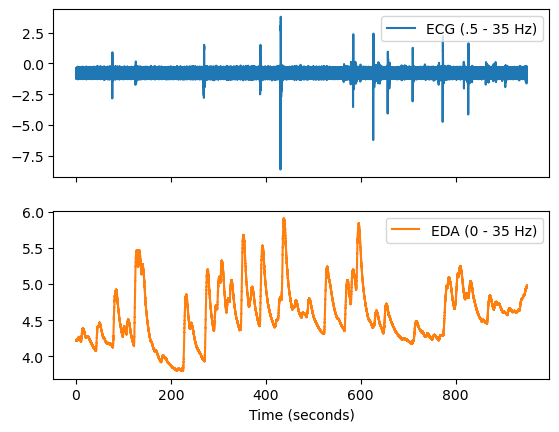

ECG of segment PB1 (only part2).nf2_2D:


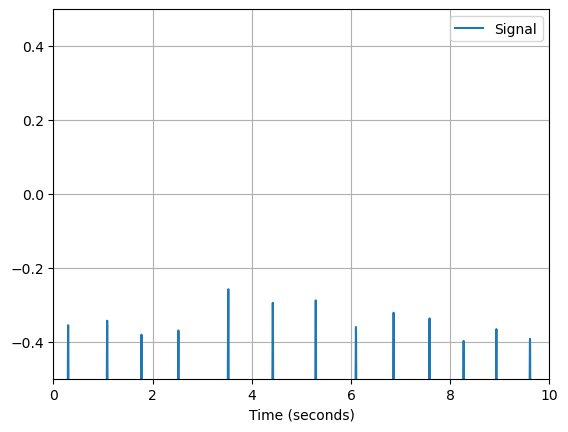

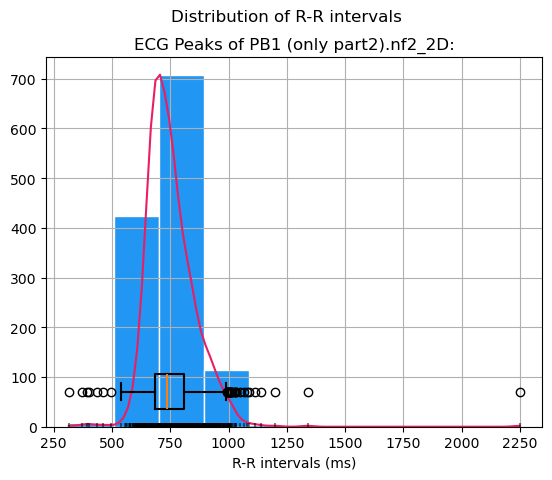

HRV of segment PB1 (only part2).nf2_2D:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  753.584591  107.65311   36.812212   97.845323   32.774701  100.351044   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0   30.864201  101.827938  98.565655  98.604848  ...      123.0     1.092197   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        674.0        830.0  30.341541  65.687053      315.0     2249.0   

     HRV_HTI  HRV_TINN  
0  22.087719       0.0  

[1 rows x 25 columns]
0    753.584591
Name: HRV_MeanNN, dtype: float64
0    107.65311
Name: HRV_SDNN, dtype: float64
0    98.565655
Name: HRV_RMSSD, dtype: float64


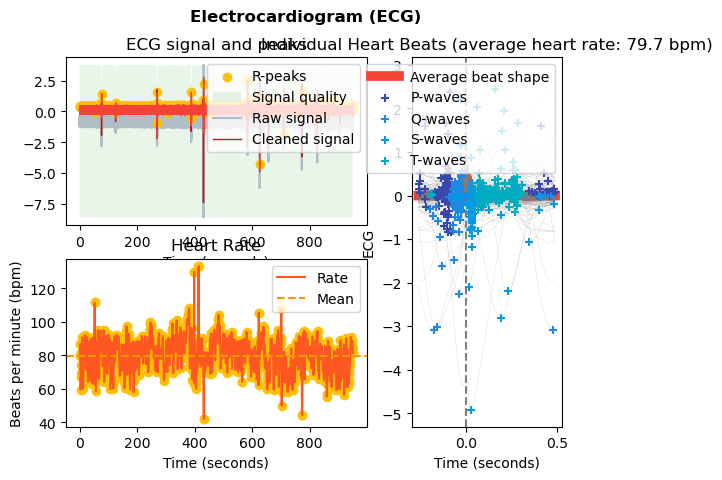

ECG analyze output of segment PB1 (only part2).nf2_2D:
  ECG_Rate_Mean             HRV_MeanNN              HRV_SDNN  \
0     79.706283  [[753.5853852263701]]  [[101.342277509053]]   

               HRV_SDANN1             HRV_SDNNI1             HRV_SDANN2  \
0  [[38.573533954541375]]  [[92.79287732131982]]  [[33.34277703194645]]   

              HRV_SDNNI2             HRV_SDANN5             HRV_SDNNI5  \
0  [[95.39037371981756]]  [[29.86500033640625]]  [[97.15022235302062]]   

               HRV_RMSSD  ...              HRV_SampEn             HRV_ShanEn  \
0  [[79.03007517517592]]  ...  [[1.1068906515472583]]  [[8.192137664610692]]   

              HRV_FuzzyEn                HRV_MSEn              HRV_CMSEn  \
0  [[0.9206594067228039]]  [[1.5813320626485918]]  [[1.453493377194026]]   

              HRV_RCMSEn                  HRV_CD                 HRV_HFD  \
0  [[1.936309631616846]]  [[1.2756470301528666]]  [[1.7504584338347706]]   

                  HRV_KFD                 HRV_LZC

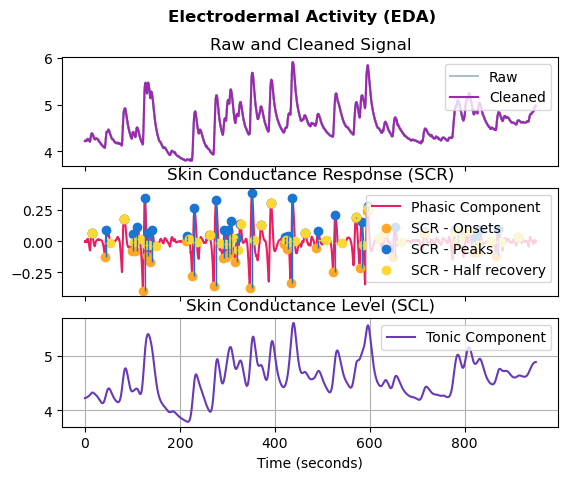

EDA of segment PB1 (only part2).nf2_2D:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         41.0                  0.180399      0.357243         0.012182   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.006911             0.825832  

For file PB1 (only part2):
segment: [stress2_ABBA] before: [None] after [nf2_2D] start [625593] end [936053]
2028515
segment: [nf2_2D] before: [stress2_ABBA] after [None] start [1126517] end [2076579] marker_inside label[nf2_2D_unlimited] marker_inside index [2028515]

File PB2:
Segment PB2.baseline:


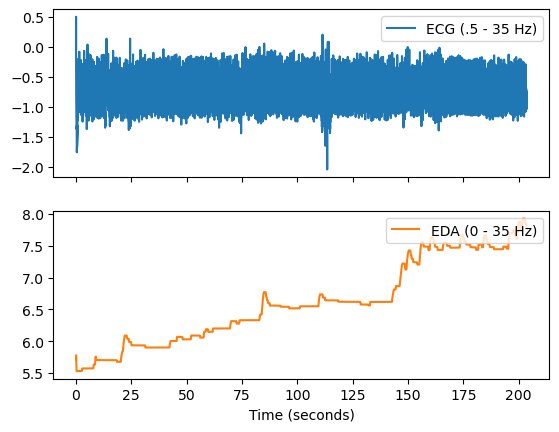

ECG of segment PB2.baseline:


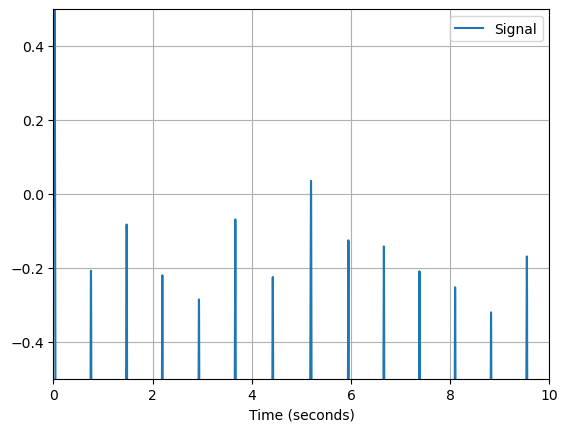

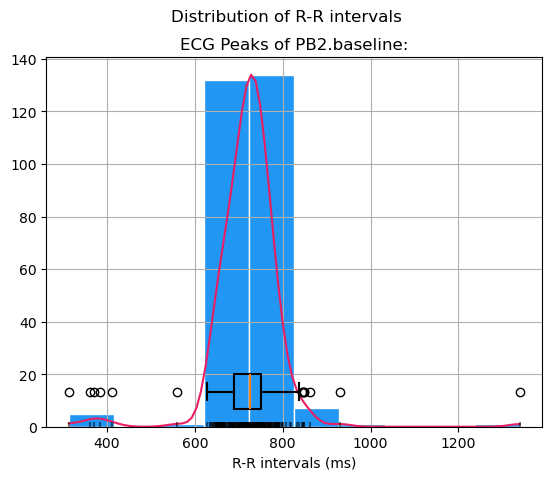

HRV of segment PB2.baseline:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  720.266904  76.766552   21.618788   73.150928         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN    89.8708  90.031689  ...       61.0     0.854188   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        682.0        759.0   6.761566   30.24911      313.0     1340.0   

     HRV_HTI  HRV_TINN  
0  12.217391  492.1875  

[1 rows x 25 columns]
0    720.266904
Name: HRV_MeanNN, dtype: float64
0    76.766552
Name: HRV_SDNN, dtype: float64
0    89.8708
Name: HRV_RMSSD, dtype: float64


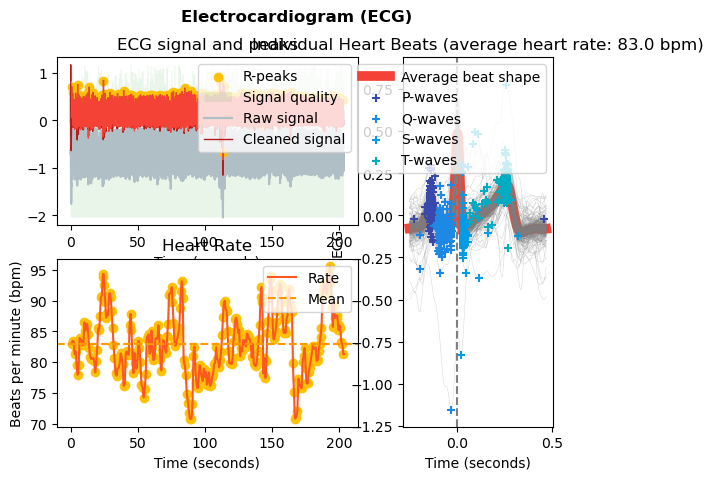

ECG analyze output of segment PB2.baseline:
  ECG_Rate_Mean             HRV_MeanNN               HRV_SDNN  \
0     83.011976  [[722.8392857142857]]  [[44.42414370914576]]   

              HRV_SDANN1             HRV_SDNNI1 HRV_SDANN2 HRV_SDNNI2  \
0  [[8.523965485788347]]  [[43.32321674351531]]    [[nan]]    [[nan]]   

  HRV_SDANN5 HRV_SDNNI5             HRV_RMSSD  ...              HRV_SampEn  \
0    [[nan]]    [[nan]]  [[20.6003966972974]]  ...  [[1.2774440816118402]]   

              HRV_ShanEn            HRV_FuzzyEn                HRV_MSEn  \
0  [[6.875142942359973]]  [[0.850258840881795]]  [[1.5121656159843933]]   

                HRV_CMSEn             HRV_RCMSEn                  HRV_CD  \
0  [[1.3864295780243874]]  [[2.124135933954487]]  [[1.6539252164991325]]   

                  HRV_HFD                 HRV_KFD                 HRV_LZC  
0  [[1.5711677761245464]]  [[2.6443205933166194]]  [[0.6677625335347652]]  

[1 rows x 92 columns]
0    722.839286
Name: HRV_MeanNN, dtype: f

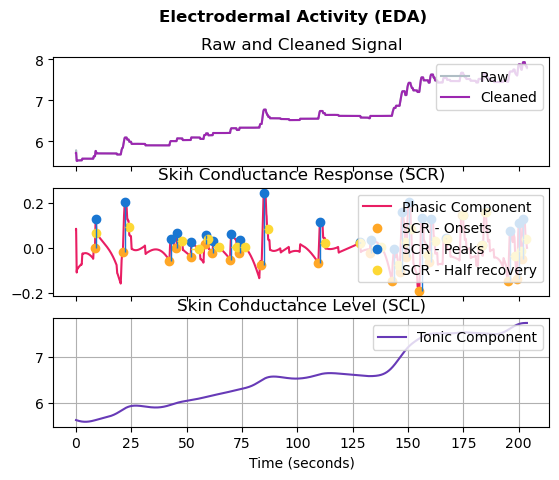

EDA of segment PB2.baseline:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         25.0                  0.129672      0.635625         0.002753   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000304             0.917387  
Segment PB2.stress1_MIST:


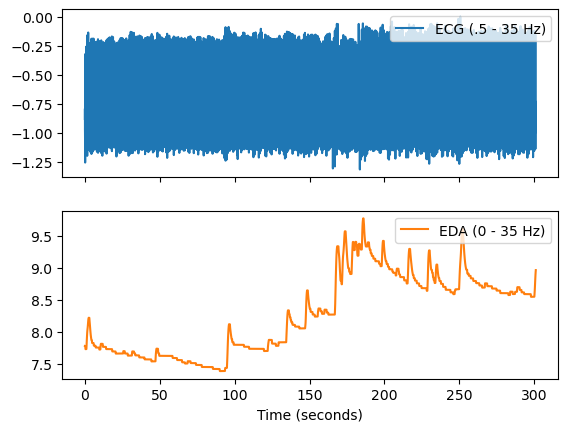

ECG of segment PB2.stress1_MIST:


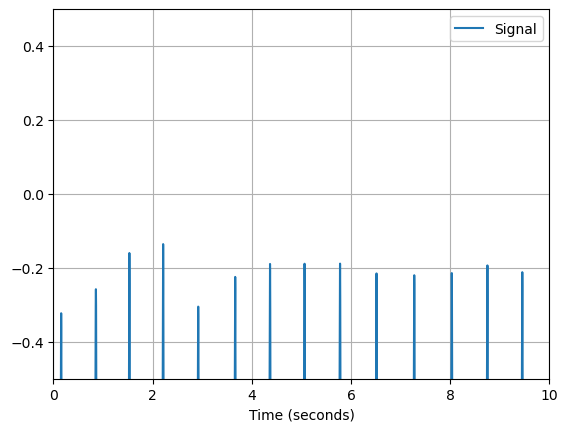

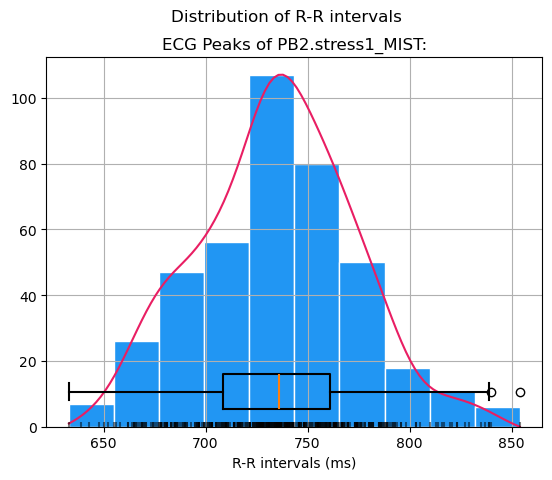

HRV of segment PB2.stress1_MIST:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  735.137255  39.834619   16.325784   36.813485         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN  22.719635  22.746568  ...      52.25     1.753312   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        701.0        767.0   2.941176  32.107843      633.0      854.0   

    HRV_HTI  HRV_TINN  
0  9.714286  164.0625  

[1 rows x 25 columns]
0    735.137255
Name: HRV_MeanNN, dtype: float64
0    39.834619
Name: HRV_SDNN, dtype: float64
0    22.719635
Name: HRV_RMSSD, dtype: float64


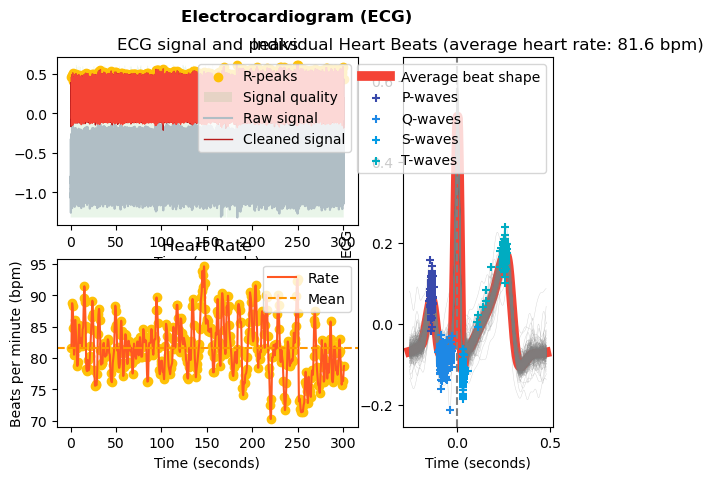

ECG analyze output of segment PB2.stress1_MIST:
  ECG_Rate_Mean             HRV_MeanNN               HRV_SDNN  \
0     81.627692  [[735.1348039215686]]  [[39.80646008911523]]   

               HRV_SDANN1              HRV_SDNNI1 HRV_SDANN2 HRV_SDNNI2  \
0  [[16.330668619663843]]  [[36.785201311407974]]    [[nan]]    [[nan]]   

  HRV_SDANN5 HRV_SDNNI5               HRV_RMSSD  ...             HRV_SampEn  \
0    [[nan]]    [[nan]]  [[22.696588623296126]]  ...  [[1.498534145331512]]   

              HRV_ShanEn             HRV_FuzzyEn                HRV_MSEn  \
0  [[6.963306733845849]]  [[1.0149151187171683]]  [[1.3362705762877196]]   

                HRV_CMSEn             HRV_RCMSEn                  HRV_CD  \
0  [[1.4218833635884547]]  [[2.320021235869907]]  [[1.7130459626422874]]   

                 HRV_HFD               HRV_KFD                 HRV_LZC  
0  [[1.640632588300941]]  [[2.59352862581651]]  [[0.8289818341590399]]  

[1 rows x 92 columns]
0    735.134804
Name: HRV_MeanNN, dt

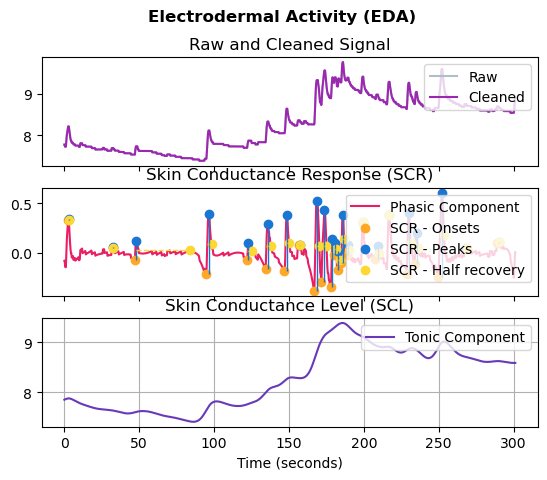

EDA of segment PB2.stress1_MIST:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         23.0                  0.302493      0.603181         0.016057   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.001574             0.935568  
Segment PB2.nf1_VR:


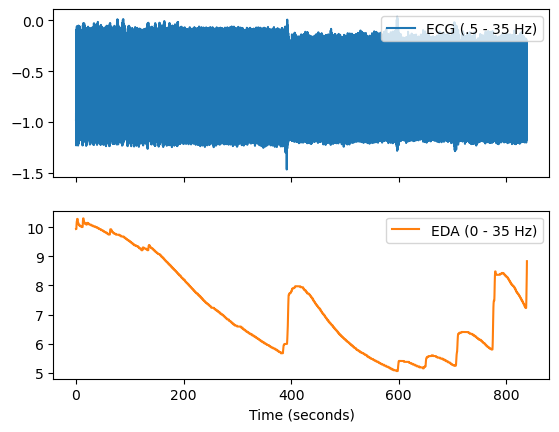

ECG of segment PB2.nf1_VR:


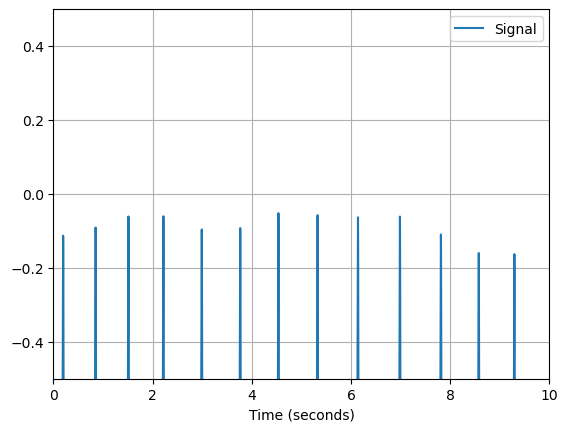

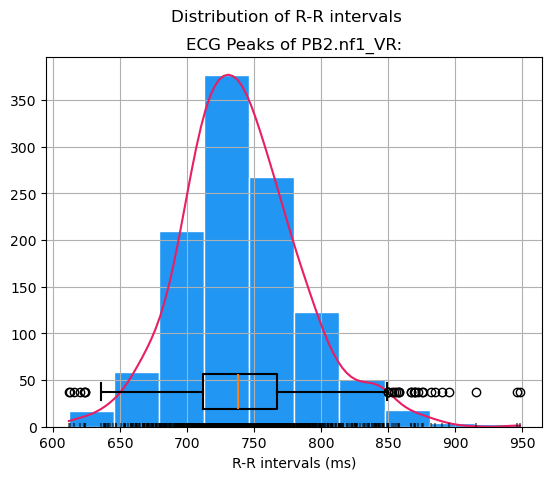

HRV of segment PB2.nf1_VR:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  741.364925  45.859615   23.816294   37.869688   22.767001   39.953855   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0   16.764823   43.094212  22.890601  22.900738  ...       55.0     2.003426   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        706.6        774.0   3.188663  33.835252      612.0      948.0   

     HRV_HTI  HRV_TINN  
0  12.010638  195.3125  

[1 rows x 25 columns]
0    741.364925
Name: HRV_MeanNN, dtype: float64
0    45.859615
Name: HRV_SDNN, dtype: float64
0    22.890601
Name: HRV_RMSSD, dtype: float64


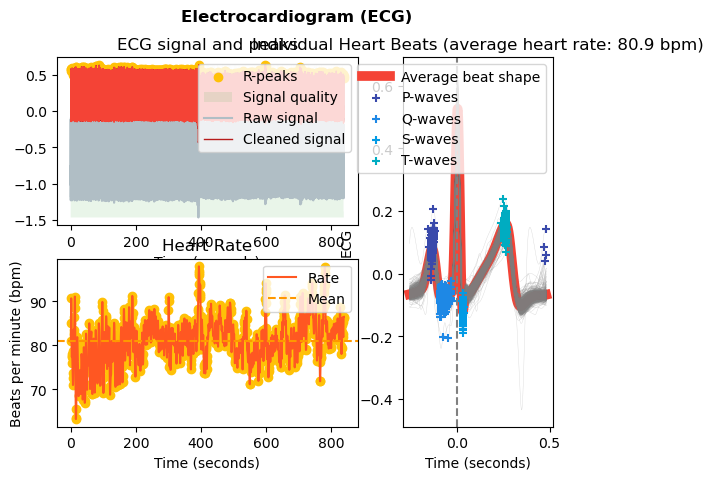

ECG analyze output of segment PB2.nf1_VR:
  ECG_Rate_Mean             HRV_MeanNN               HRV_SDNN  \
0     80.941983  [[741.3649247121347]]  [[45.82645000877289]]   

               HRV_SDANN1             HRV_SDNNI1              HRV_SDANN2  \
0  [[23.817338749703495]]  [[37.82616247911234]]  [[22.767682222273635]]   

              HRV_SDNNI2           HRV_SDANN5              HRV_SDNNI5  \
0  [[39.91093532627912]]  [[16.763164624568]]  [[43.062010494446646]]   

                HRV_RMSSD  ...              HRV_SampEn             HRV_ShanEn  \
0  [[22.819597773694248]]  ...  [[1.1752937659220704]]  [[7.329801357144514]]   

             HRV_FuzzyEn               HRV_MSEn               HRV_CMSEn  \
0  [[0.879953187303723]]  [[1.575145785190943]]  [[1.4190779357992265]]   

               HRV_RCMSEn                  HRV_CD                 HRV_HFD  \
0  [[1.9792334792771988]]  [[1.4862949967229924]]  [[1.7085863416878455]]   

                  HRV_KFD                 HRV_LZC  
0  [[2

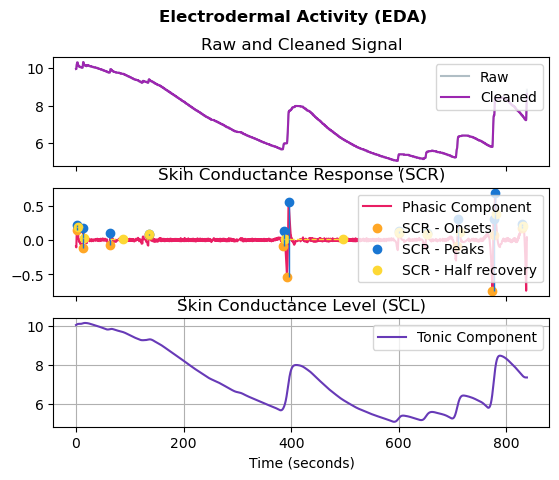

EDA of segment PB2.nf1_VR:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         12.0                  0.336874      1.551525          0.00534   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000803             0.982576  
Segment PB2.stress2_ABBA:


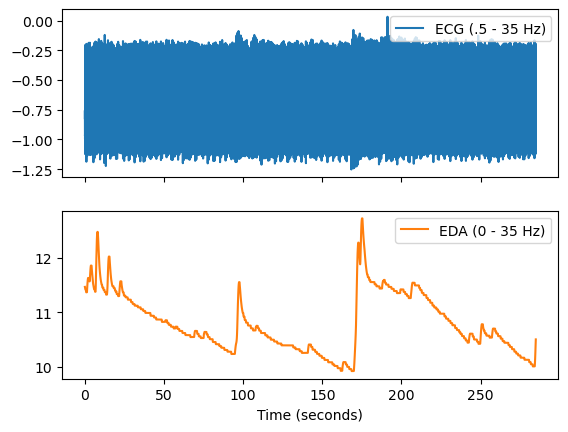

ECG of segment PB2.stress2_ABBA:


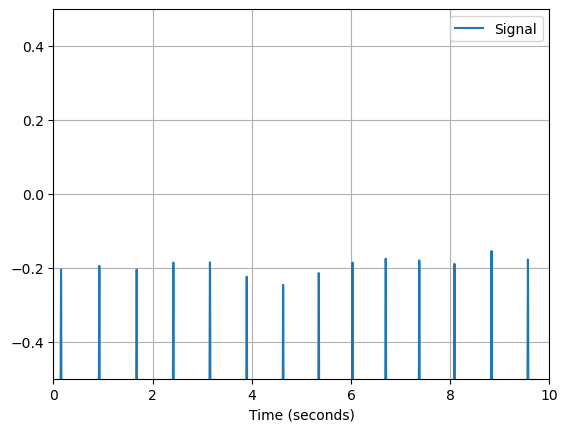

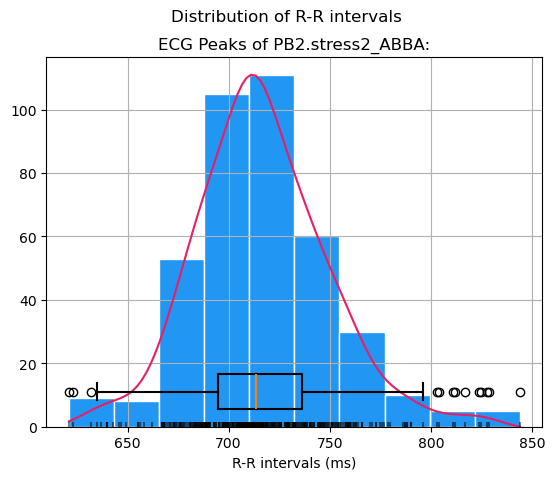

HRV of segment PB2.stress2_ABBA:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  716.840909  34.966276    7.681257   33.499345         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD  HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN  20.474869  20.50083  ...       41.5     1.707766   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        689.0        742.0   1.262626   29.79798      621.0      844.0   

    HRV_HTI  HRV_TINN  
0  7.764706   140.625  

[1 rows x 25 columns]
0    716.840909
Name: HRV_MeanNN, dtype: float64
0    34.966276
Name: HRV_SDNN, dtype: float64
0    20.474869
Name: HRV_RMSSD, dtype: float64


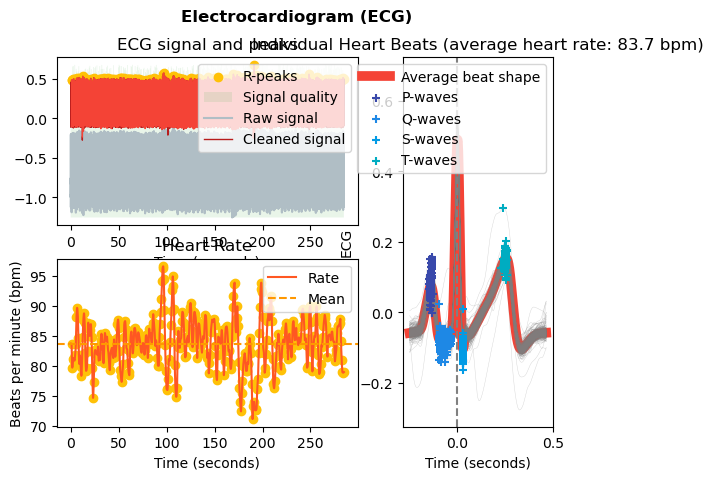

ECG analyze output of segment PB2.stress2_ABBA:
  ECG_Rate_Mean             HRV_MeanNN               HRV_SDNN  \
0     83.710042  [[716.8434343434343]]  [[34.92684191130002]]   

              HRV_SDANN1             HRV_SDNNI1 HRV_SDANN2 HRV_SDNNI2  \
0  [[7.690416574616798]]  [[33.45373451918329]]    [[nan]]    [[nan]]   

  HRV_SDANN5 HRV_SDNNI5               HRV_RMSSD  ...              HRV_SampEn  \
0    [[nan]]    [[nan]]  [[20.437431531259907]]  ...  [[1.4129034698478553]]   

              HRV_ShanEn             HRV_FuzzyEn               HRV_MSEn  \
0  [[6.697057992978892]]  [[1.0032282504602579]]  [[1.239406734664324]]   

               HRV_CMSEn              HRV_RCMSEn                 HRV_CD  \
0  [[1.309591577327874]]  [[1.9921885738477814]]  [[1.634728304419738]]   

                  HRV_HFD                 HRV_KFD                HRV_LZC  
0  [[1.6708074481194026]]  [[2.8420177438571206]]  [[0.828069574654104]]  

[1 rows x 92 columns]
0    716.843434
Name: HRV_MeanNN, dtyp

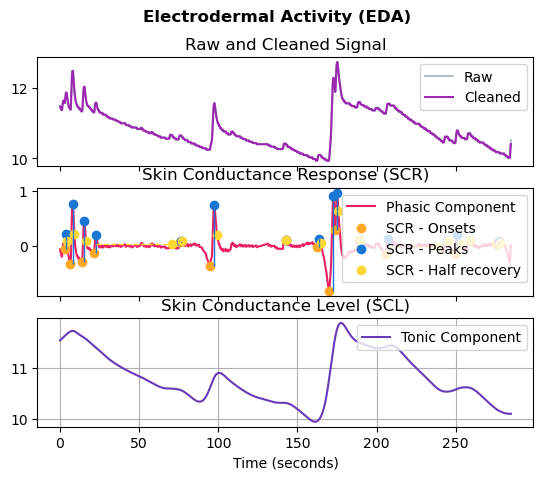

EDA of segment PB2.stress2_ABBA:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         16.0                  0.423712      0.495994         0.019768   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000707             0.783823  
Segment PB2.nf2_2D:


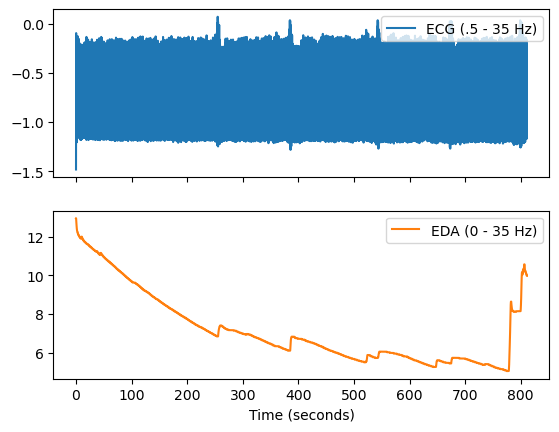

ECG of segment PB2.nf2_2D:


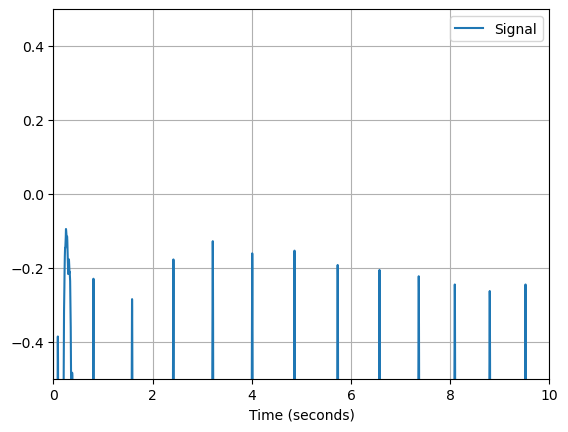

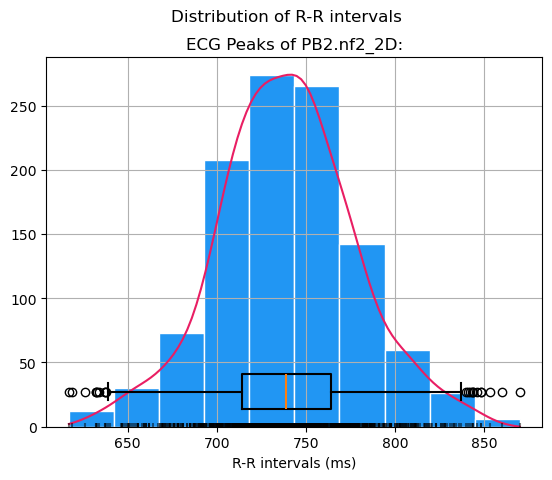

HRV of segment PB2.nf2_2D:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  739.148723  39.672596   16.713182   36.646459   13.832469    37.38539   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0   15.498091   38.194288  18.636587  18.645095  ...       50.0     2.128748   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        709.0        770.0   1.459854  26.368613      617.0      870.0   

     HRV_HTI  HRV_TINN  
0  11.183673  179.6875  

[1 rows x 25 columns]
0    739.148723
Name: HRV_MeanNN, dtype: float64
0    39.672596
Name: HRV_SDNN, dtype: float64
0    18.636587
Name: HRV_RMSSD, dtype: float64


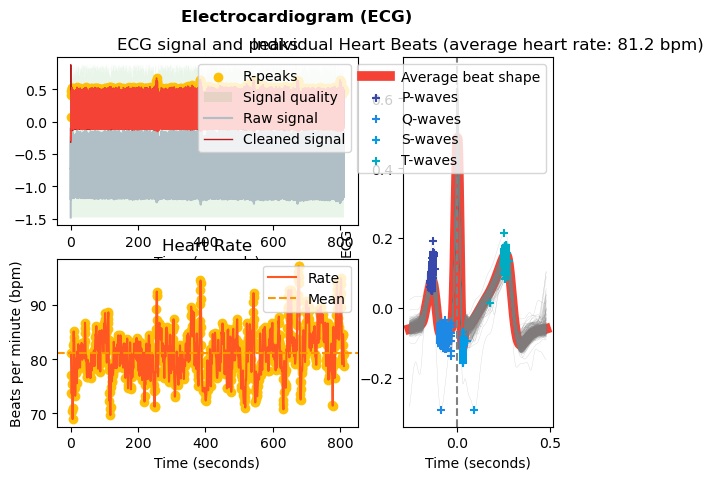

ECG analyze output of segment PB2.nf2_2D:
  ECG_Rate_Mean             HRV_MeanNN               HRV_SDNN  \
0     81.180024  [[739.1496350364963]]  [[39.66201338564084]]   

              HRV_SDANN1             HRV_SDNNI1              HRV_SDANN2  \
0  [[16.71763382540254]]  [[36.62849131883197]]  [[13.830815924575829]]   

              HRV_SDNNI2              HRV_SDANN5              HRV_SDNNI5  \
0  [[37.37212690343498]]  [[15.498810472628152]]  [[38.182132882328716]]   

                HRV_RMSSD  ...             HRV_SampEn             HRV_ShanEn  \
0  [[18.558583043061507]]  ...  [[1.319187223243982]]  [[7.177018336477733]]   

              HRV_FuzzyEn                HRV_MSEn              HRV_CMSEn  \
0  [[0.8772892124827136]]  [[1.4274837481802998]]  [[1.422138306542994]]   

              HRV_RCMSEn                  HRV_CD                 HRV_HFD  \
0  [[2.174597738059044]]  [[1.5863519648107542]]  [[1.6150031528672149]]   

                 HRV_KFD                 HRV_LZC  
0  [[

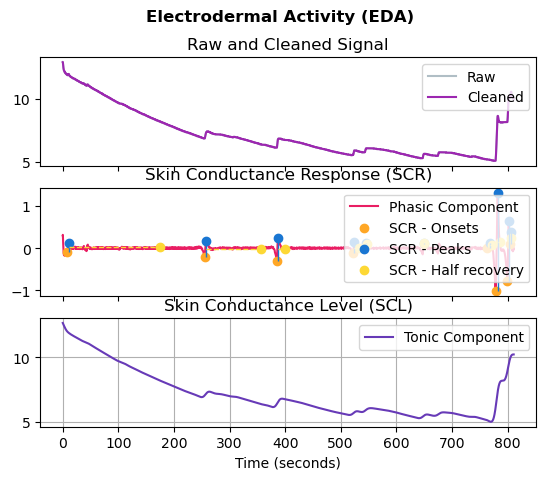

EDA of segment PB2.nf2_2D:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         10.0                  0.561344      1.819674         0.005043   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000647             0.962548  

For file PB2:
segment: [baseline] before: [None] after [stress1_MIST] start [0] end [203723]
segment: [stress1_MIST] before: [baseline] after [nf1_VR] start [203723] end [504807]
1562554
segment: [nf1_VR] before: [stress1_MIST] after [stress2_ABBA] start [781103] end [1619563] marker_inside label[nf1_VR_unlimited] marker_inside index [1562554]
segment: [stress2_ABBA] before: [nf1_VR] after [nf2_2D] start [2030022] end [2314915]
3223086
segment: [nf2_2D] before: [stress2_ABBA] after [None] start [2443500] end [3254602] marker_inside label[nf2_2D_unlimited] marker_inside index [3223086]

File PB3:
Segment PB3.baseline:


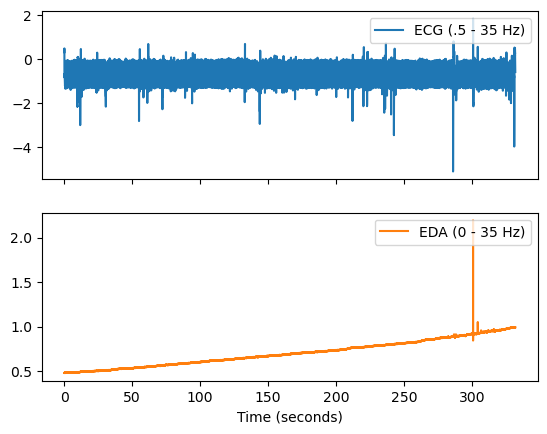

ECG of segment PB3.baseline:


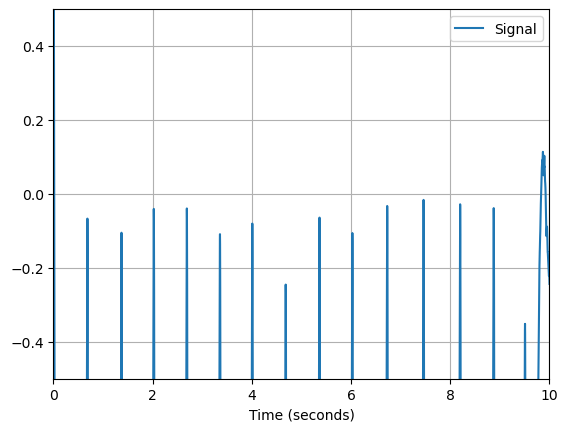

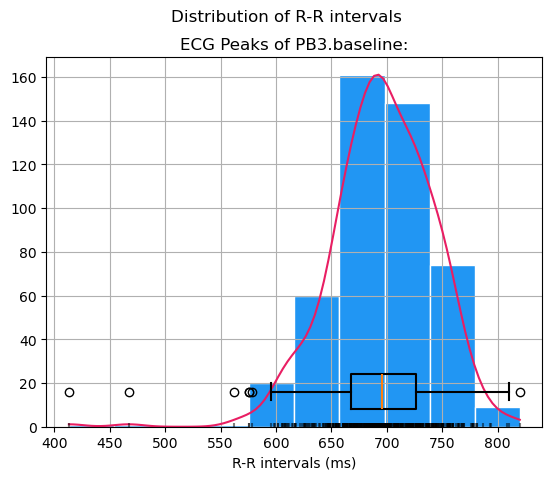

HRV of segment PB3.baseline:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  695.682105  46.328241   15.720606   42.235612   14.912743   42.936948   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN  44.595013  44.638351  ...       58.5     1.038866   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        662.0        734.2  16.421053  54.315789      413.0      820.0   

     HRV_HTI  HRV_TINN  
0  11.585366     375.0  

[1 rows x 25 columns]
0    695.682105
Name: HRV_MeanNN, dtype: float64
0    46.328241
Name: HRV_SDNN, dtype: float64
0    44.595013
Name: HRV_RMSSD, dtype: float64


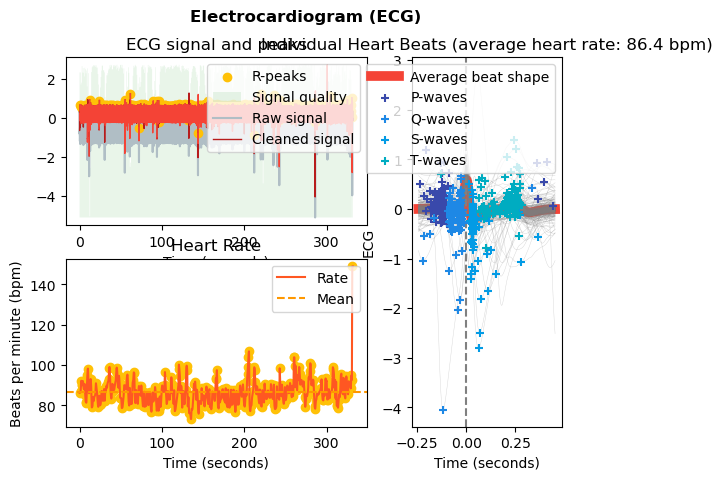

ECG analyze output of segment PB3.baseline:
  ECG_Rate_Mean             HRV_MeanNN                HRV_SDNN  \
0     86.381316  [[695.6589473684211]]  [[44.805692767491735]]   

             HRV_SDANN1             HRV_SDNNI1              HRV_SDANN2  \
0  [[15.7276159981448]]  [[40.03851727698617]]  [[14.916283647465498]]   

              HRV_SDNNI2 HRV_SDANN5 HRV_SDNNI5               HRV_RMSSD  ...  \
0  [[40.81367185427819]]    [[nan]]    [[nan]]  [[38.139926696820204]]  ...   

             HRV_SampEn             HRV_ShanEn             HRV_FuzzyEn  \
0  [[1.75589798661139]]  [[7.066146227801614]]  [[1.2666197714755651]]   

                HRV_MSEn               HRV_CMSEn              HRV_RCMSEn  \
0  [[1.625394387348122]]  [[1.4114175427295548]]  [[2.0718799644145562]]   

                   HRV_CD                 HRV_HFD                 HRV_KFD  \
0  [[1.7238626427602797]]  [[1.7897455872387527]]  [[2.6873729428747524]]   

                  HRV_LZC  
0  [[0.9172576872793625]]  

[

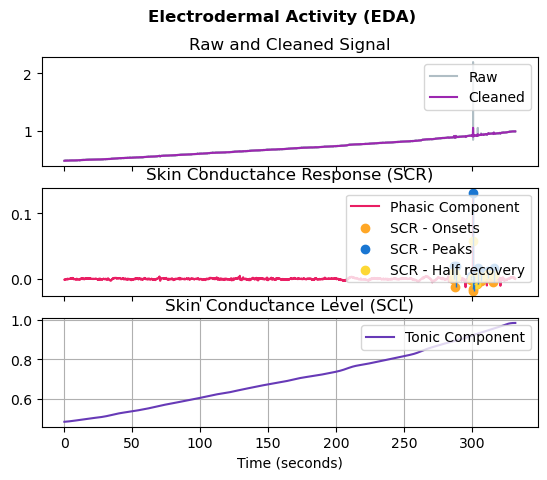

EDA of segment PB3.baseline:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0          9.0                   0.03297      0.142912         0.000002   

   EDA_SympatheticN  EDA_Autocorrelation  
0           0.00005             0.960121  
Segment PB3.stress1_MIST:


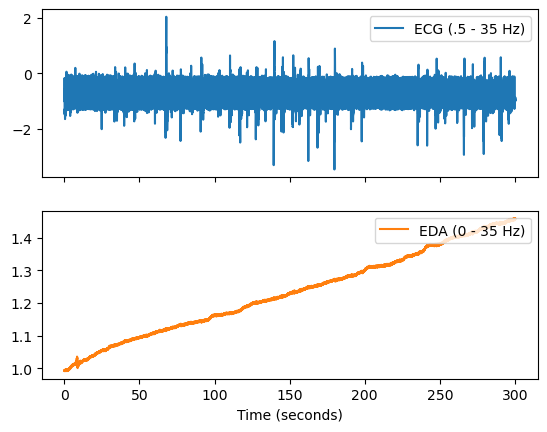

ECG of segment PB3.stress1_MIST:


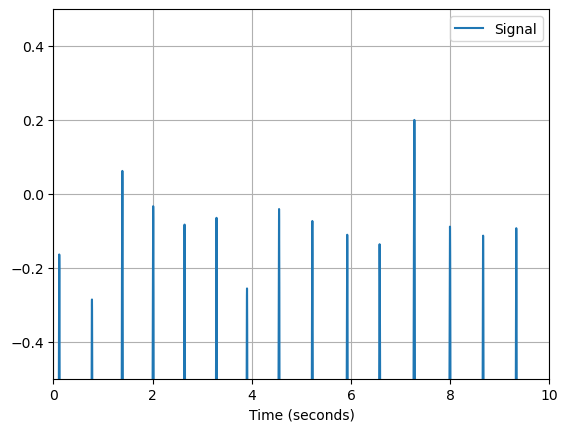

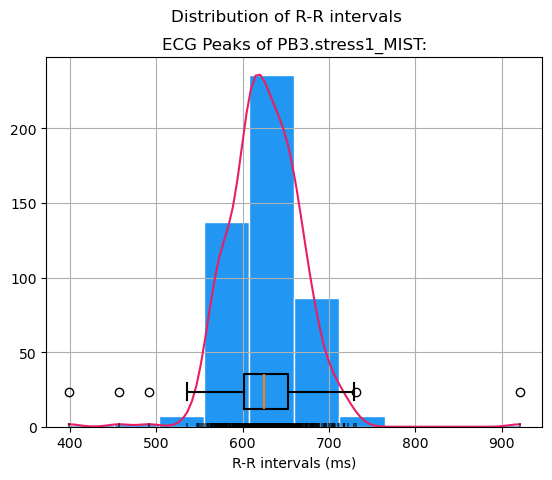

HRV of segment PB3.stress1_MIST:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  626.475891  42.179214   15.609213   39.752782         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN  43.997422  44.043659  ...       51.0     0.958675   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        595.0        659.0   5.660377  44.863732      399.0      921.0   

     HRV_HTI  HRV_TINN  
0  10.369565  304.6875  

[1 rows x 25 columns]
0    626.475891
Name: HRV_MeanNN, dtype: float64
0    42.179214
Name: HRV_SDNN, dtype: float64
0    43.997422
Name: HRV_RMSSD, dtype: float64


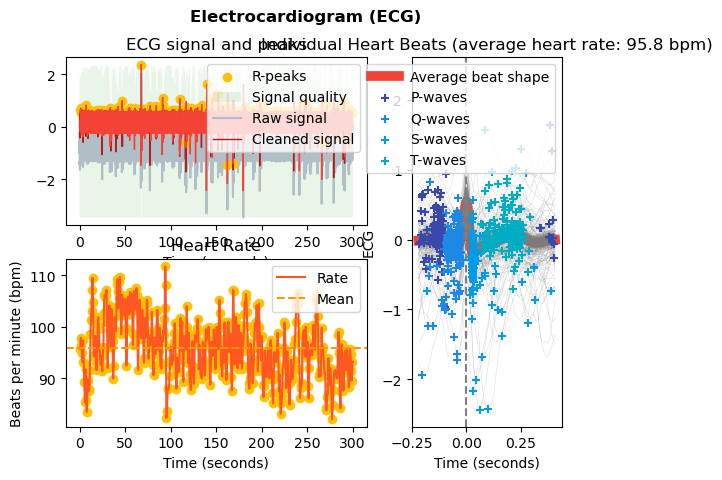

ECG analyze output of segment PB3.stress1_MIST:
  ECG_Rate_Mean             HRV_MeanNN                HRV_SDNN  \
0     95.789406  [[626.4758909853249]]  [[37.353832015923146]]   

               HRV_SDANN1             HRV_SDNNI1 HRV_SDANN2 HRV_SDNNI2  \
0  [[15.609224992773807]]  [[34.56905315904037]]    [[nan]]    [[nan]]   

  HRV_SDANN5 HRV_SDNNI5               HRV_RMSSD  ...              HRV_SampEn  \
0    [[nan]]    [[nan]]  [[26.857036697447974]]  ...  [[1.7207752263561784]]   

              HRV_ShanEn            HRV_FuzzyEn               HRV_MSEn  \
0  [[6.977857520982884]]  [[1.185508746330771]]  [[1.304492343687083]]   

               HRV_CMSEn              HRV_RCMSEn                  HRV_CD  \
0  [[1.415064291865609]]  [[2.1188295926433725]]  [[1.8358624820454206]]   

                  HRV_HFD                HRV_KFD                 HRV_LZC  
0  [[1.7816606990089838]]  [[3.557473547885514]]  [[0.9140344388768764]]  

[1 rows x 92 columns]
0    626.475891
Name: HRV_MeanNN, 

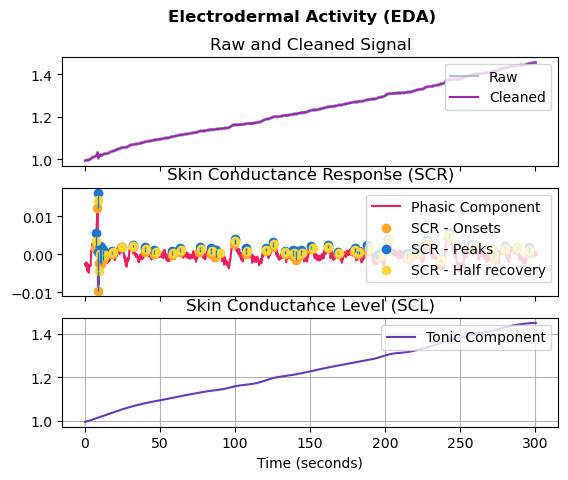

EDA of segment PB3.stress1_MIST:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         44.0                  0.001601       0.12702         0.000003   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000018             0.955182  
Segment PB3.nf1_2D:


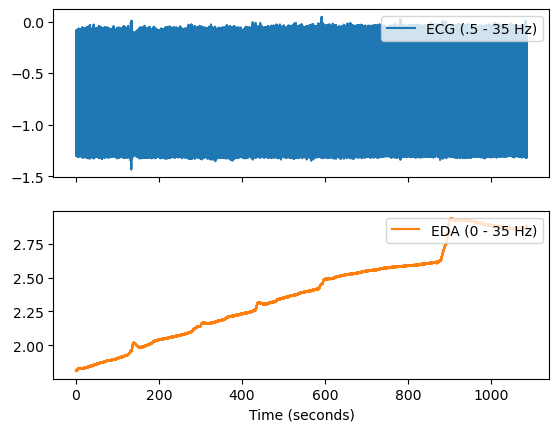

ECG of segment PB3.nf1_2D:


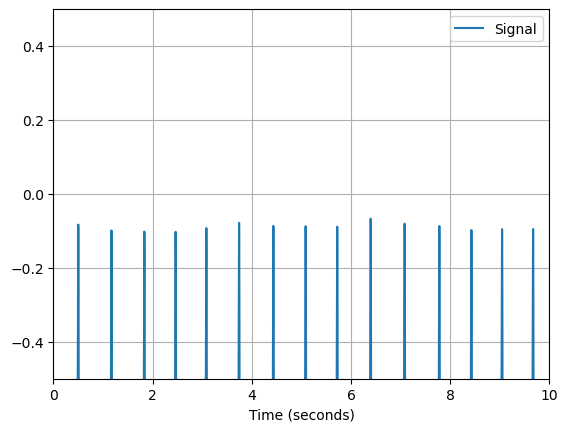

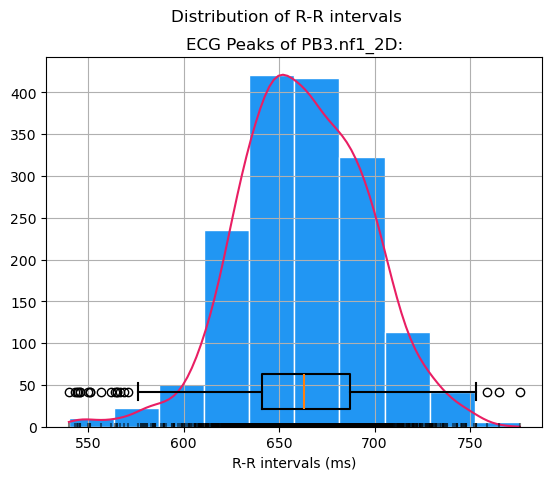

HRV of segment PB3.nf1_2D:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  662.823673  34.061121    9.197986   32.632399    6.831503    33.37655   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0     4.71126   33.001682  25.912575  25.920485  ...       46.0     1.314463   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        635.0        692.0   4.697987  43.990238      540.0      776.0   

     HRV_HTI  HRV_TINN  
0  10.055215       0.0  

[1 rows x 25 columns]
0    662.823673
Name: HRV_MeanNN, dtype: float64
0    34.061121
Name: HRV_SDNN, dtype: float64
0    25.912575
Name: HRV_RMSSD, dtype: float64


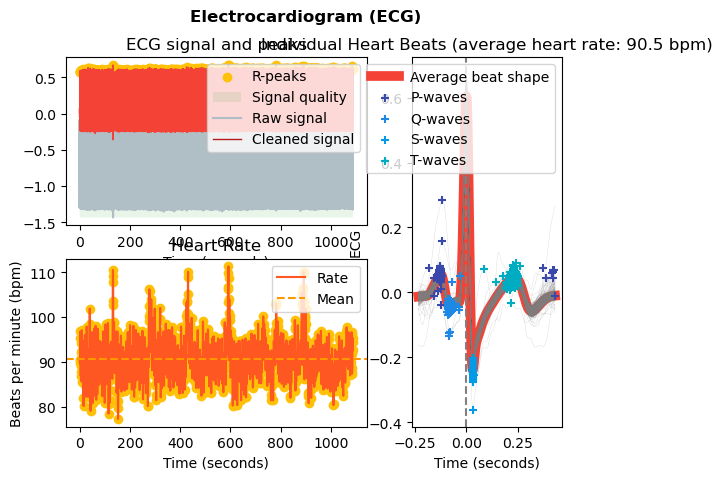

ECG analyze output of segment PB3.nf1_2D:
  ECG_Rate_Mean             HRV_MeanNN               HRV_SDNN  \
0     90.536012  [[662.8242830994509]]  [[34.07756534777885]]   

              HRV_SDANN1             HRV_SDNNI1             HRV_SDANN2  \
0  [[9.200362472122178]]  [[32.64894699899043]]  [[6.832866716741518]]   

              HRV_SDNNI2            HRV_SDANN5             HRV_SDNNI5  \
0  [[33.39139849596466]]  [[4.70994669893232]]  [[33.02336636551355]]   

                HRV_RMSSD  ...              HRV_SampEn            HRV_ShanEn  \
0  [[25.923210073461593]]  ...  [[1.4676478789348146]]  [[7.01263394199508]]   

              HRV_FuzzyEn                HRV_MSEn               HRV_CMSEn  \
0  [[1.2175156974621444]]  [[1.0893956026709708]]  [[1.4007928170982735]]   

               HRV_RCMSEn                  HRV_CD                 HRV_HFD  \
0  [[2.1884189877411115]]  [[1.7140088240420506]]  [[1.8291833334565772]]   

                 HRV_KFD                 HRV_LZC  
0  [[4.04

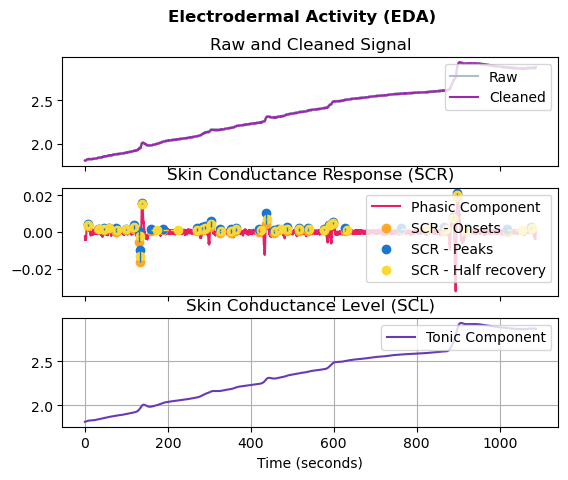

EDA of segment PB3.nf1_2D:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         37.0                   0.00172      0.331362         0.000014   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000113             0.990036  
Segment PB3.stress2_ABBA:


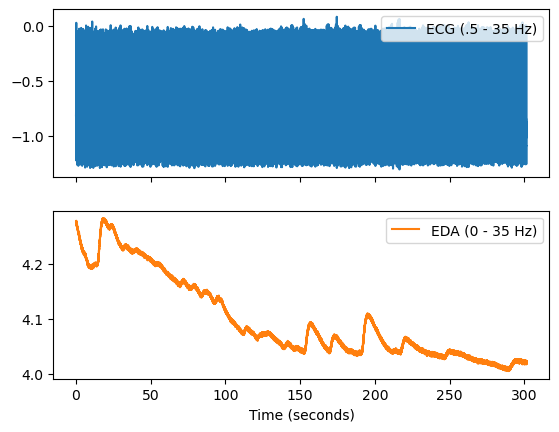

ECG of segment PB3.stress2_ABBA:


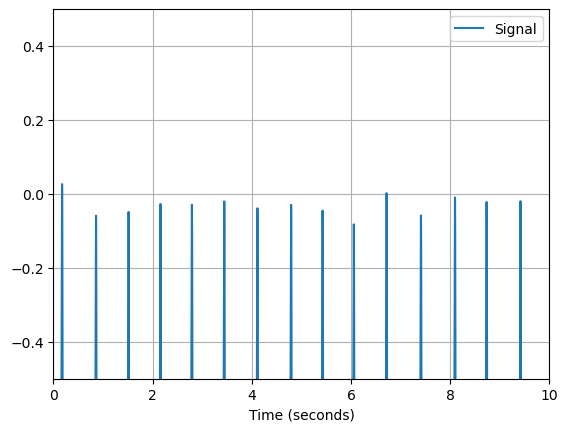

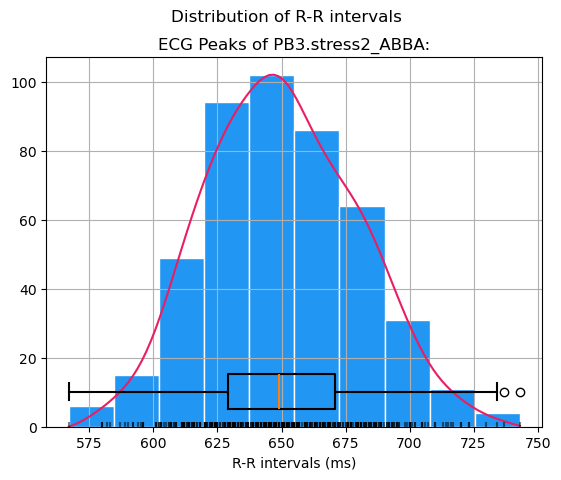

HRV of segment PB3.stress2_ABBA:
   HRV_MeanNN  HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  650.424242  30.46298   13.335428   28.091193   11.940058    27.65643   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN  26.413777  26.442429  ...       42.0     1.153299   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        624.0        677.0   4.978355  44.805195      567.0      743.0   

    HRV_HTI  HRV_TINN  
0  8.884615  148.4375  

[1 rows x 25 columns]
0    650.424242
Name: HRV_MeanNN, dtype: float64
0    30.46298
Name: HRV_SDNN, dtype: float64
0    26.413777
Name: HRV_RMSSD, dtype: float64


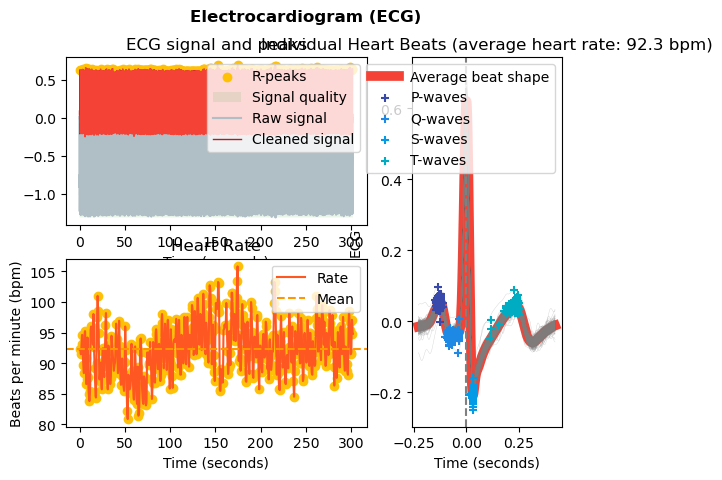

ECG analyze output of segment PB3.stress2_ABBA:
  ECG_Rate_Mean             HRV_MeanNN                HRV_SDNN  \
0     92.265739  [[650.4242424242424]]  [[30.433913627162955]]   

               HRV_SDANN1              HRV_SDNNI1             HRV_SDANN2  \
0  [[13.338469105735772]]  [[28.057158685235017]]  [[11.94325218017648]]   

               HRV_SDNNI2 HRV_SDANN5 HRV_SDNNI5               HRV_RMSSD  ...  \
0  [[27.627200487138037]]    [[nan]]    [[nan]]  [[26.364498248513634]]  ...   

               HRV_SampEn             HRV_ShanEn             HRV_FuzzyEn  \
0  [[1.5625506984107544]]  [[6.720908192457418]]  [[1.3039722478929274]]   

                 HRV_MSEn               HRV_CMSEn             HRV_RCMSEn  \
0  [[1.4534469494418345]]  [[1.3893645135178865]]  [[2.083763982074462]]   

                   HRV_CD                HRV_HFD                HRV_KFD  \
0  [[1.7849729666156446]]  [[1.912381750343048]]  [[4.299603555345839]]   

                  HRV_LZC  
0  [[0.9388218680289

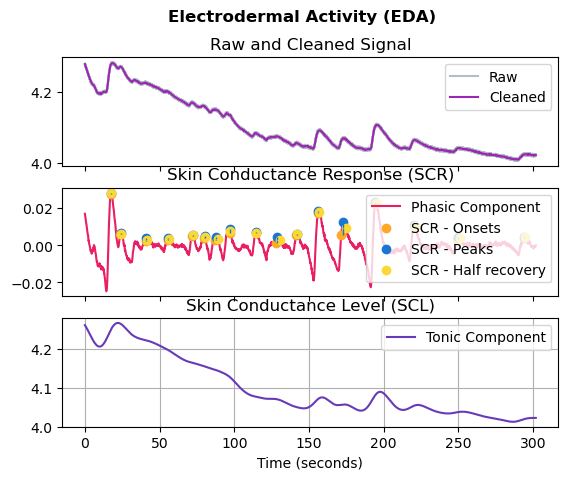

EDA of segment PB3.stress2_ABBA:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         17.0                  0.001418      0.075258         0.000078   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000028             0.943562  
Segment PB3.nf2_VR:


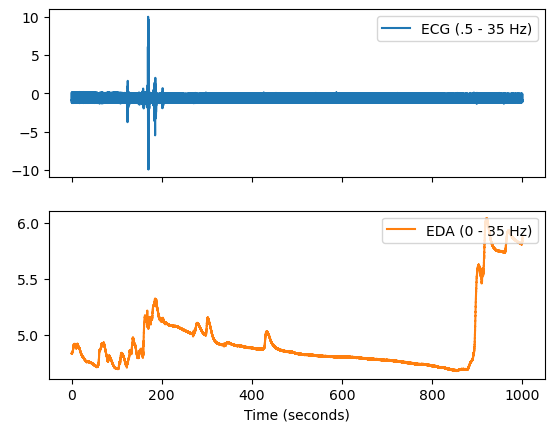

ECG of segment PB3.nf2_VR:


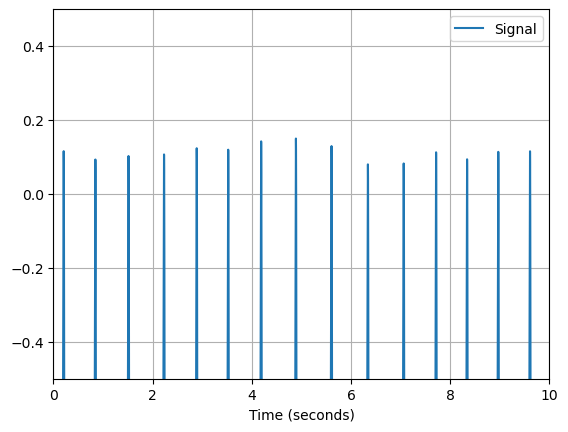

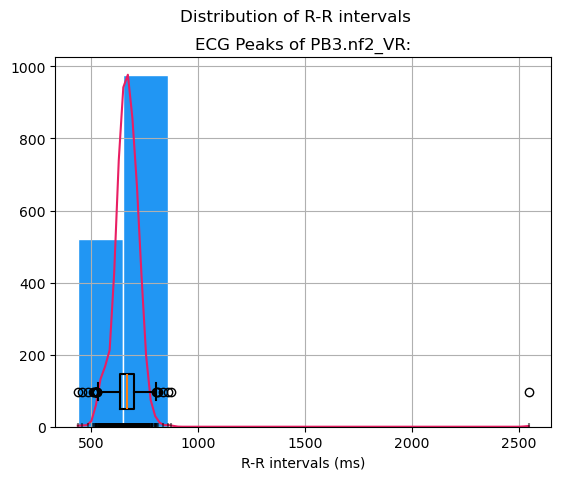

HRV of segment PB3.nf2_VR:
   HRV_MeanNN  HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  665.682212  71.39813   16.896686   53.928244   15.280329   58.171896   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0    6.623105    64.53386  82.399689  82.427168  ...       68.0     0.866485   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        626.0        709.0  10.126582  51.165889      437.0     2545.0   

     HRV_HTI  HRV_TINN  
0  14.861386       0.0  

[1 rows x 25 columns]
0    665.682212
Name: HRV_MeanNN, dtype: float64
0    71.39813
Name: HRV_SDNN, dtype: float64
0    82.399689
Name: HRV_RMSSD, dtype: float64


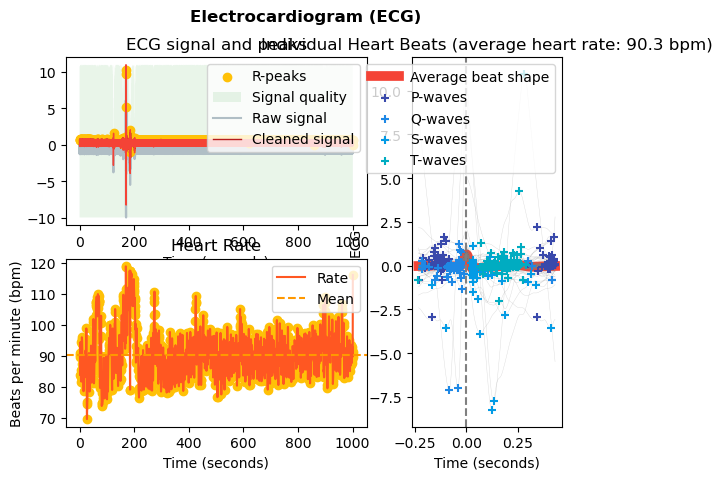

ECG analyze output of segment PB3.nf2_VR:
  ECG_Rate_Mean             HRV_MeanNN               HRV_SDNN  \
0      90.34169  [[664.2571428571429]]  [[51.76518102513841]]   

               HRV_SDANN1              HRV_SDNNI1              HRV_SDANN2  \
0  [[18.843422011234686]]  [[45.451734921993186]]  [[18.308558531871974]]   

              HRV_SDNNI2            HRV_SDANN5             HRV_SDNNI5  \
0  [[47.17603039527465]]  [[8.92335952686635]]  [[49.95791092310952]]   

              HRV_RMSSD  ...              HRV_SampEn             HRV_ShanEn  \
0  [[31.9691714864792]]  ...  [[1.3156306616050806]]  [[7.542338742510721]]   

             HRV_FuzzyEn                HRV_MSEn               HRV_CMSEn  \
0  [[1.056166468470161]]  [[1.0944569920820046]]  [[1.3413299396876492]]   

               HRV_RCMSEn                  HRV_CD                 HRV_HFD  \
0  [[1.9722997612759987]]  [[1.6641742984829464]]  [[1.7586431027905431]]   

                  HRV_KFD                 HRV_LZC  
0  [[3

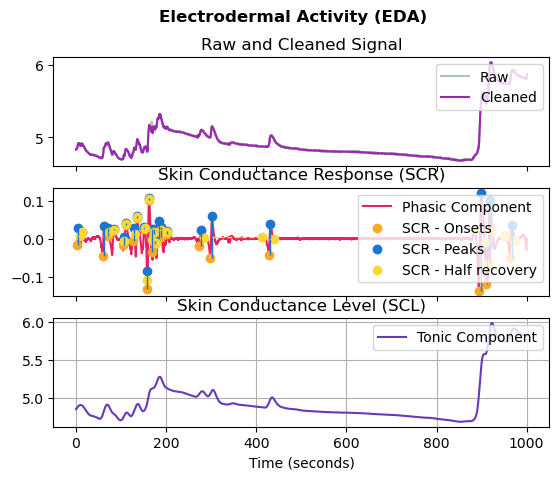

EDA of segment PB3.nf2_VR:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         27.0                  0.046973      0.310286         0.000717   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000654             0.968548  

For file PB3:
segment: [baseline] before: [None] after [stress1_MIST] start [12550] end [344507]
segment: [stress1_MIST] before: [baseline] after [nf1_2D] start [344507] end [644714]
1780916
segment: [nf1_2D] before: [stress1_MIST] after [stress2_ABBA] start [881405] end [1968321] marker_inside label[nf1_2D_unlimited] marker_inside index [1780916]
segment: [stress2_ABBA] before: [nf1_2D] after [nf2_VR] start [2477702] end [2779498]
4062223
segment: [nf2_VR] before: [stress2_ABBA] after [None] start [3165299] end [4165931] marker_inside label[nf2_VR_unlimited] marker_inside index [4062223]

File PB4:
Segment PB4.baseline:


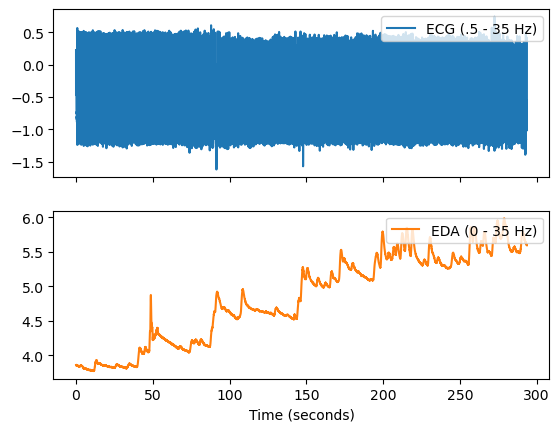

ECG of segment PB4.baseline:


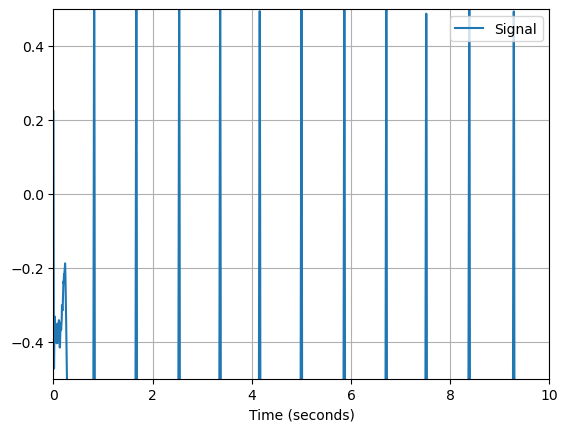

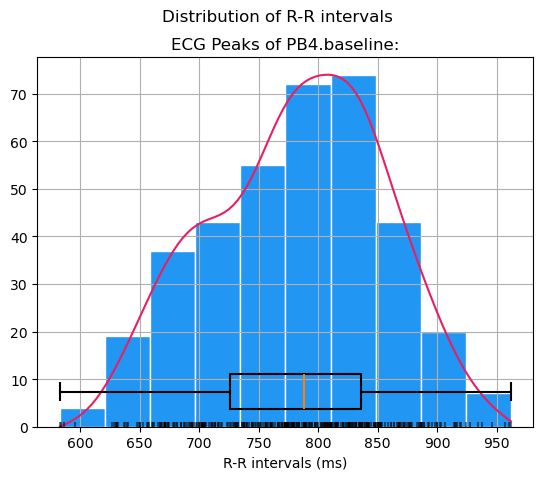

HRV of segment PB4.baseline:
   HRV_MeanNN  HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  781.240642  76.68938   27.385314   72.758732         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN  54.463506  54.534567  ...     109.75     1.408087   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        704.6        847.0  32.887701  69.518717      583.0      962.0   

   HRV_HTI  HRV_TINN  
0     17.0  226.5625  

[1 rows x 25 columns]
0    781.240642
Name: HRV_MeanNN, dtype: float64
0    76.68938
Name: HRV_SDNN, dtype: float64
0    54.463506
Name: HRV_RMSSD, dtype: float64


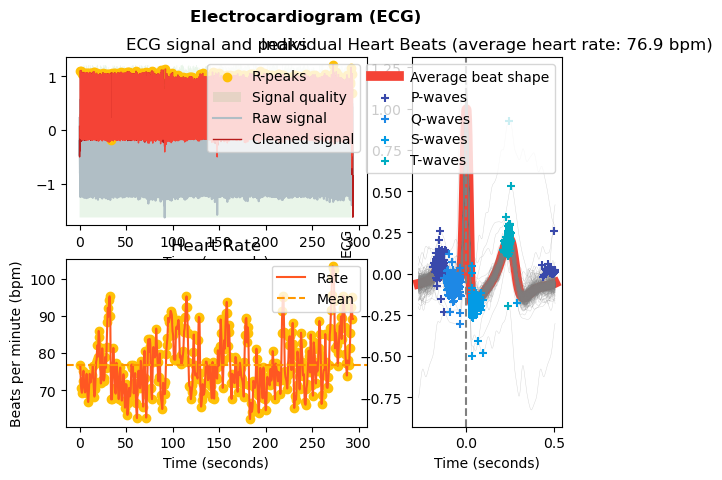

ECG analyze output of segment PB4.baseline:
  ECG_Rate_Mean           HRV_MeanNN               HRV_SDNN  \
0     76.853367  [[781.24064171123]]  [[76.63492967113432]]   

               HRV_SDANN1             HRV_SDNNI1 HRV_SDANN2 HRV_SDNNI2  \
0  [[27.388430156056167]]  [[72.69639942964848]]    [[nan]]    [[nan]]   

  HRV_SDANN5 HRV_SDNNI5               HRV_RMSSD  ...              HRV_SampEn  \
0    [[nan]]    [[nan]]  [[54.465523935670824]]  ...  [[1.6240901892209707]]   

              HRV_ShanEn             HRV_FuzzyEn                HRV_MSEn  \
0  [[7.521663319591095]]  [[1.1677776341838935]]  [[1.6382385147204521]]   

              HRV_CMSEn             HRV_RCMSEn                  HRV_CD  \
0  [[1.39820056648693]]  [[2.161501177603326]]  [[1.8195590184732642]]   

                  HRV_HFD                 HRV_KFD                 HRV_LZC  
0  [[1.7518896410693212]]  [[3.2316915610733497]]  [[0.7769904054443306]]  

[1 rows x 92 columns]
0    781.240642
Name: HRV_MeanNN, dtype: f

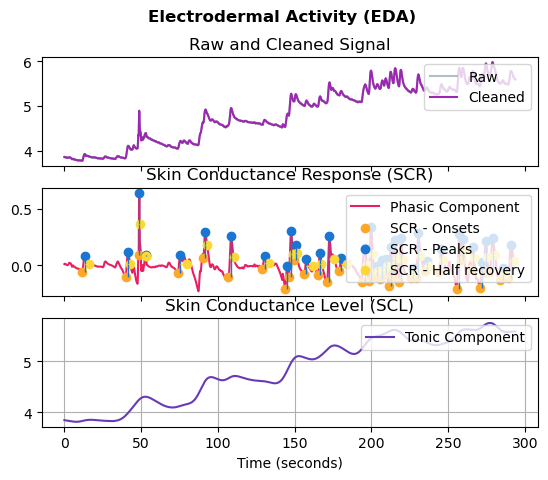

EDA of segment PB4.baseline:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         35.0                  0.242828      0.629573         0.007125   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.002802             0.935082  
Segment PB4.stress1_ABBA:


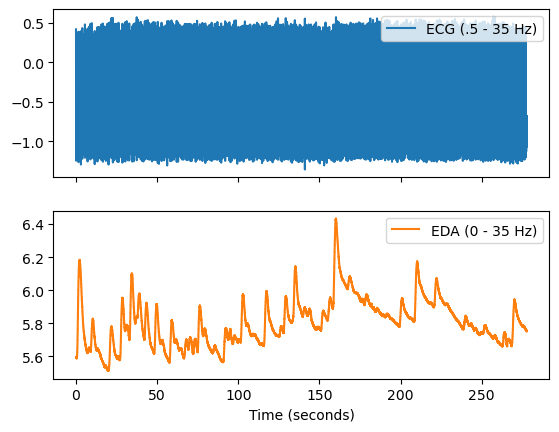

ECG of segment PB4.stress1_ABBA:


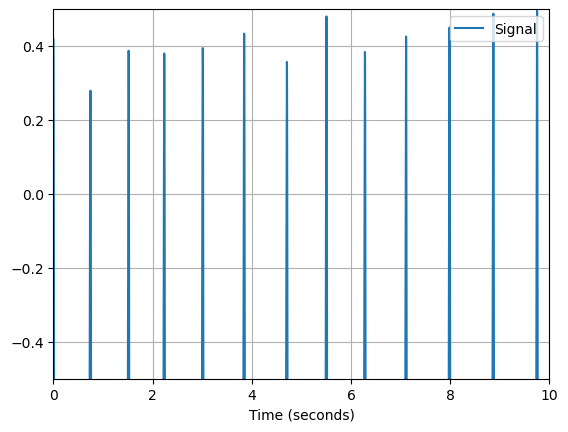

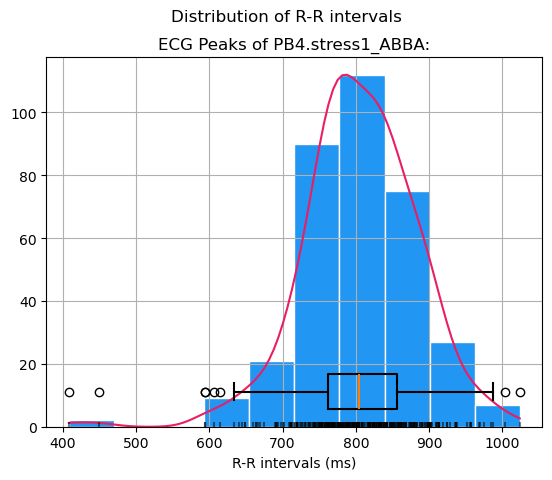

HRV of segment PB4.stress1_ABBA:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  805.781341  78.299892   31.275765   73.642581         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN  80.013869  80.130967  ...       94.0     0.978579   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        752.4        868.6  42.857143  79.591837      408.0     1024.0   

     HRV_HTI  HRV_TINN  
0  16.333333  429.6875  

[1 rows x 25 columns]
0    805.781341
Name: HRV_MeanNN, dtype: float64
0    78.299892
Name: HRV_SDNN, dtype: float64
0    80.013869
Name: HRV_RMSSD, dtype: float64


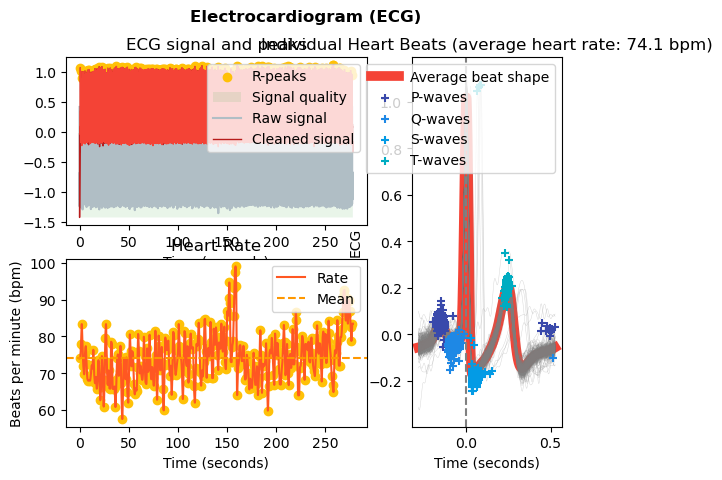

ECG analyze output of segment PB4.stress1_ABBA:
  ECG_Rate_Mean             HRV_MeanNN               HRV_SDNN  \
0     74.090695  [[810.5073313782991]]  [[71.83623597484755]]   

              HRV_SDANN1             HRV_SDNNI1 HRV_SDANN2 HRV_SDNNI2  \
0  [[36.01184091927405]]  [[65.49916174898252]]    [[nan]]    [[nan]]   

  HRV_SDANN5 HRV_SDNNI5              HRV_RMSSD  ...              HRV_SampEn  \
0    [[nan]]    [[nan]]  [[65.36575826027857]]  ...  [[1.8041819892266122]]   

              HRV_ShanEn            HRV_FuzzyEn               HRV_MSEn  \
0  [[7.341000244145381]]  [[1.359242738190207]]  [[1.064660696860821]]   

                HRV_CMSEn             HRV_RCMSEn                  HRV_CD  \
0  [[1.4510935473751063]]  [[1.998320970917486]]  [[1.8339920519671211]]   

                 HRV_HFD                 HRV_KFD                 HRV_LZC  
0  [[1.952094468934812]]  [[3.4978860168756603]]  [[0.9869358274515159]]  

[1 rows x 92 columns]
0    810.507331
Name: HRV_MeanNN, dtype:

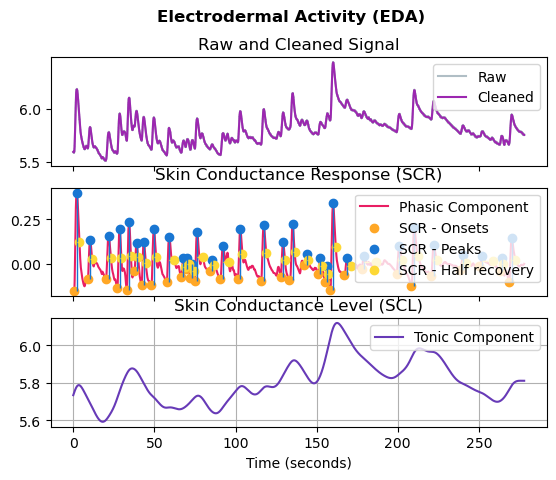

EDA of segment PB4.stress1_ABBA:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         32.0                  0.205725      0.114615         0.004661   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000898             0.553131  
Segment PB4.nf1_2D:


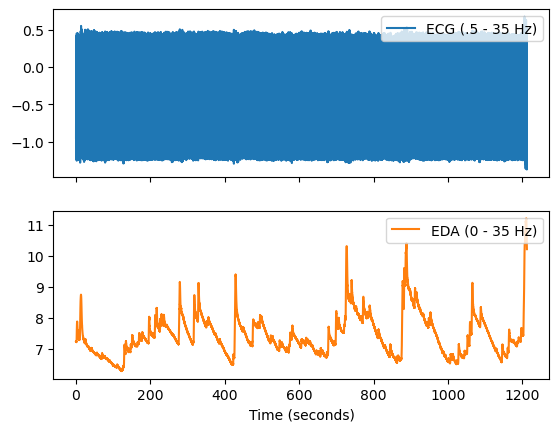

ECG of segment PB4.nf1_2D:


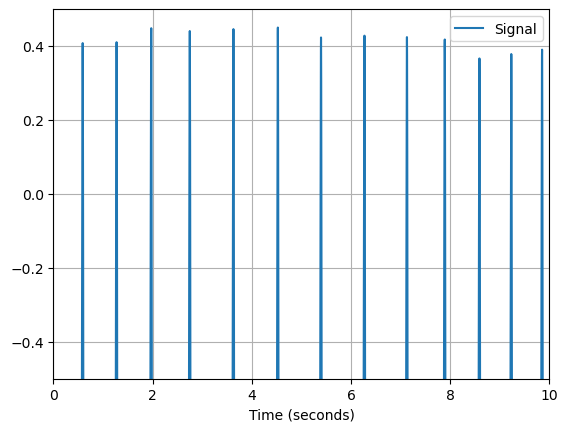

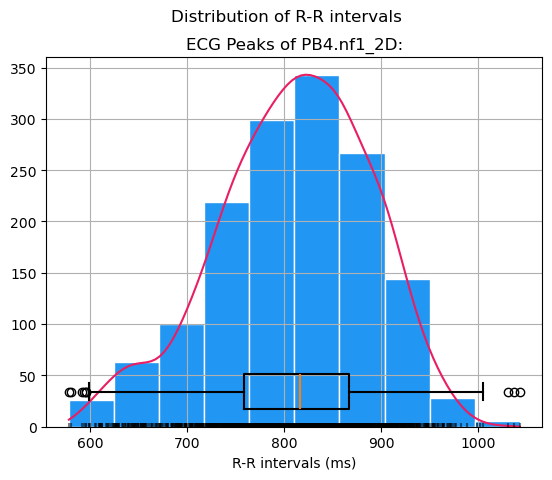

HRV of segment PB4.nf1_2D:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  810.050836  80.149167   21.991177   74.566874   10.197063   78.474833   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0    11.17694   78.614248  57.781451  57.800775  ...      108.0     1.387109   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        744.0        881.0  40.267559  75.986622      578.0     1043.0   

     HRV_HTI  HRV_TINN  
0  21.985294    406.25  

[1 rows x 25 columns]
0    810.050836
Name: HRV_MeanNN, dtype: float64
0    80.149167
Name: HRV_SDNN, dtype: float64
0    57.781451
Name: HRV_RMSSD, dtype: float64


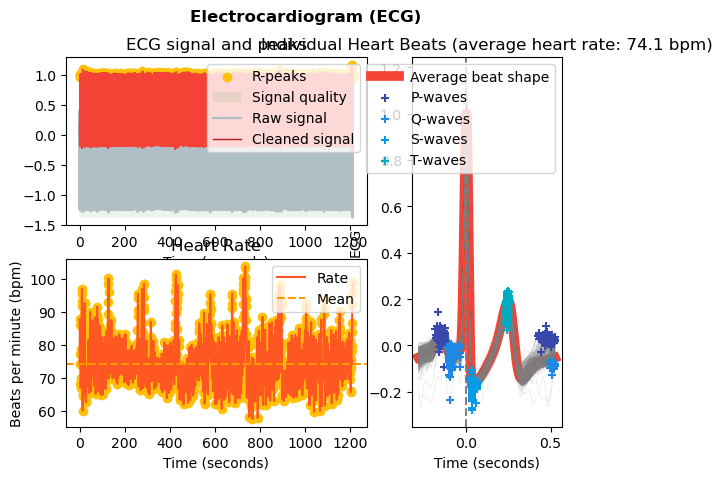

ECG analyze output of segment PB4.nf1_2D:
  ECG_Rate_Mean             HRV_MeanNN               HRV_SDNN  \
0     74.110848  [[810.0508361204013]]  [[80.15740094761435]]   

               HRV_SDANN1             HRV_SDNNI1              HRV_SDANN2  \
0  [[21.992369421053958]]  [[74.58186330293015]]  [[10.197494693648729]]   

              HRV_SDNNI2             HRV_SDANN5             HRV_SDNNI5  \
0  [[78.48609942120383]]  [[11.17781572460551]]  [[78.62524626882256]]   

               HRV_RMSSD  ...              HRV_SampEn             HRV_ShanEn  \
0  [[57.78343796289076]]  ...  [[1.4084828410250334]]  [[8.119341213639292]]   

             HRV_FuzzyEn                HRV_MSEn               HRV_CMSEn  \
0  [[1.189783162384805]]  [[1.0672271355149099]]  [[1.4083849936503126]]   

              HRV_RCMSEn                 HRV_CD                 HRV_HFD  \
0  [[2.097532891780577]]  [[1.783020154938635]]  [[1.8353614469063735]]   

                  HRV_KFD                 HRV_LZC  
0  [[3.5

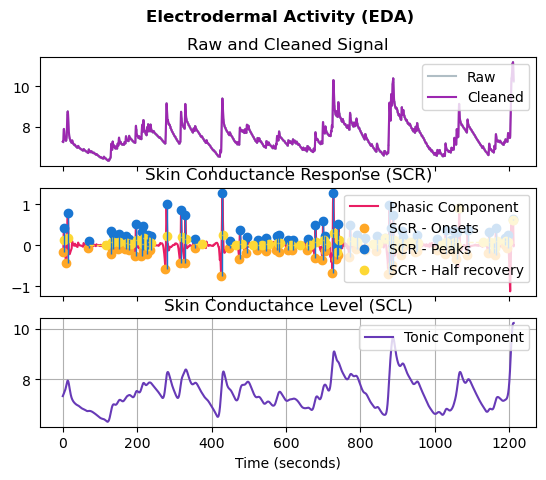

EDA of segment PB4.nf1_2D:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         61.0                  0.550405      0.621374         0.025592   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.006114             0.798854  
Segment PB4.stress2_MIST:


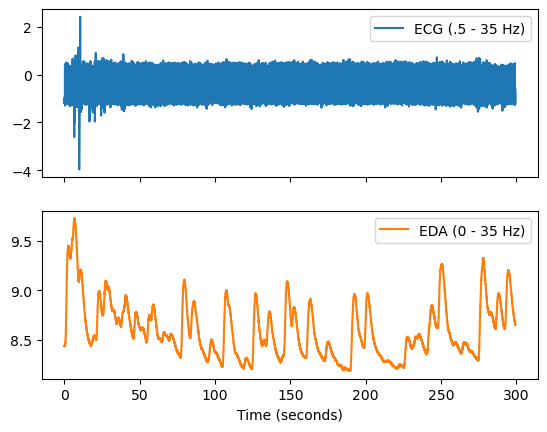

ECG of segment PB4.stress2_MIST:


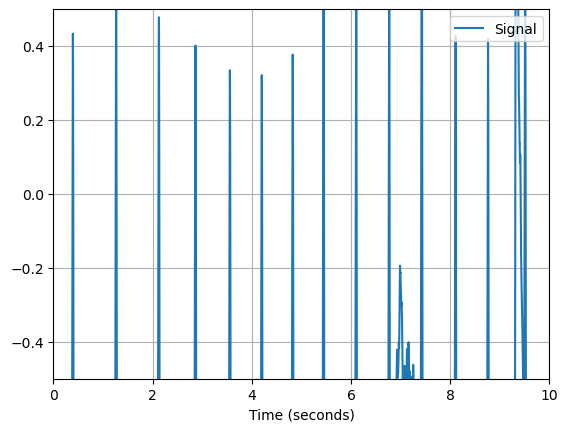

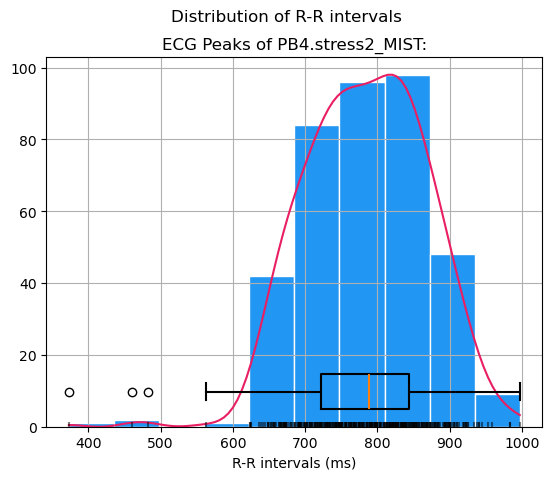

HRV of segment PB4.stress2_MIST:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  783.391076  84.984004   15.937753   83.075327         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN  70.965373  71.058918  ...      122.0     1.197542   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        710.0        858.0  39.895013   71.91601      373.0      997.0   

     HRV_HTI  HRV_TINN  
0  22.411765  429.6875  

[1 rows x 25 columns]
0    783.391076
Name: HRV_MeanNN, dtype: float64
0    84.984004
Name: HRV_SDNN, dtype: float64
0    70.965373
Name: HRV_RMSSD, dtype: float64


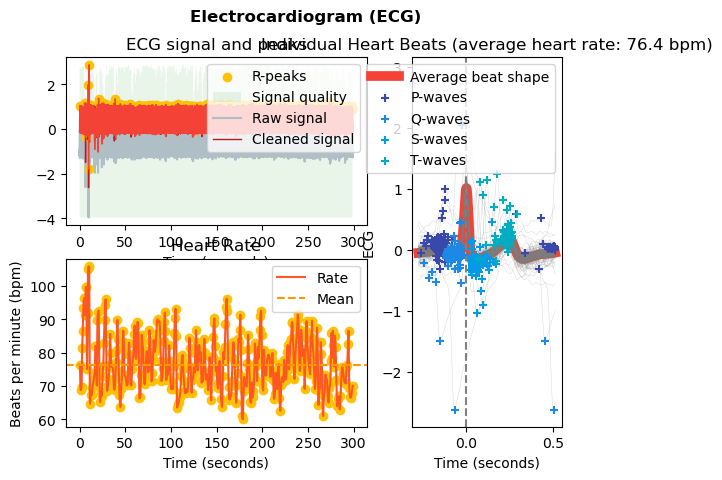

ECG analyze output of segment PB4.stress2_MIST:
  ECG_Rate_Mean  HRV_MeanNN               HRV_SDNN             HRV_SDANN1  \
0     76.445039  [[785.45]]  [[80.99741111208529]]  [[12.37802424017098]]   

             HRV_SDNNI1 HRV_SDANN2 HRV_SDNNI2 HRV_SDANN5 HRV_SDNNI5  \
0  [[80.2580781800463]]    [[nan]]    [[nan]]    [[nan]]    [[nan]]   

               HRV_RMSSD  ...             HRV_SampEn             HRV_ShanEn  \
0  [[64.95925250099579]]  ...  [[1.678430783921052]]  [[7.538427492810994]]   

              HRV_FuzzyEn                HRV_MSEn               HRV_CMSEn  \
0  [[1.2006912579396352]]  [[1.5192977947957191]]  [[1.3401411454534753]]   

               HRV_RCMSEn                  HRV_CD               HRV_HFD  \
0  [[2.1962785098887667]]  [[1.8348889402588133]]  [[1.81131977619899]]   

                 HRV_KFD                HRV_LZC  
0  [[3.234900044852142]]  [[0.834433309232224]]  

[1 rows x 92 columns]
0    785.45
Name: HRV_MeanNN, dtype: float64
0    80.997411
Name: 

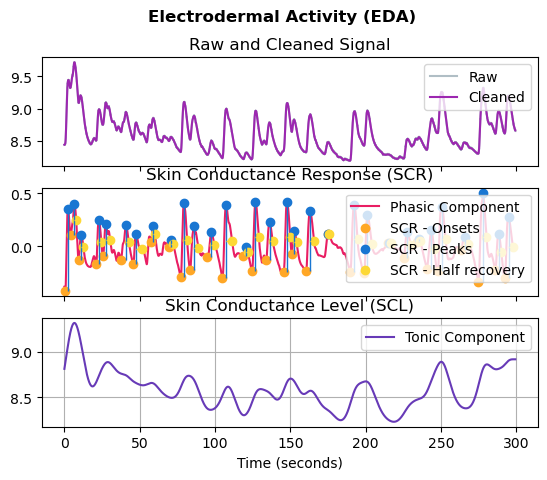

EDA of segment PB4.stress2_MIST:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         31.0                  0.378479      0.210982         0.022139   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.001848              0.39215  
Segment PB4.nf2_VR:


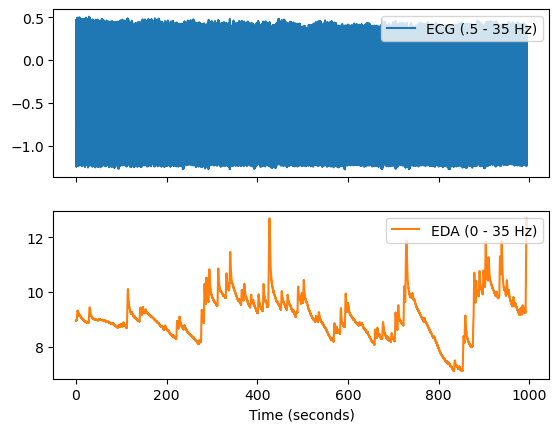

ECG of segment PB4.nf2_VR:


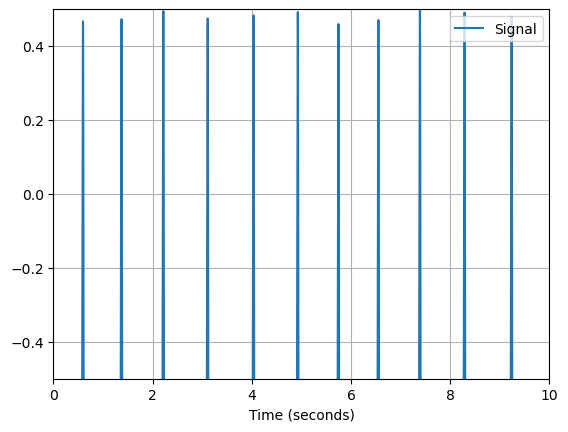

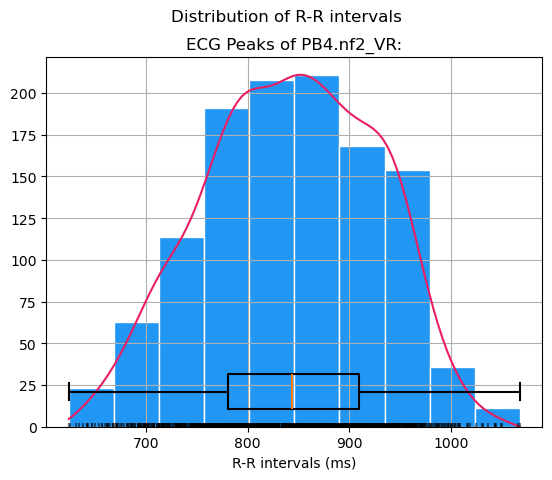

HRV of segment PB4.nf2_VR:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  842.433418  85.539839   16.069144   83.145479   10.620203   85.980872   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0    7.514784   87.311708  64.414629  64.441987  ...      129.0     1.327957   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        766.0        923.0  45.971162  76.844784      624.0     1068.0   

   HRV_HTI  HRV_TINN  
0  24.5625  414.0625  

[1 rows x 25 columns]
0    842.433418
Name: HRV_MeanNN, dtype: float64
0    85.539839
Name: HRV_SDNN, dtype: float64
0    64.414629
Name: HRV_RMSSD, dtype: float64


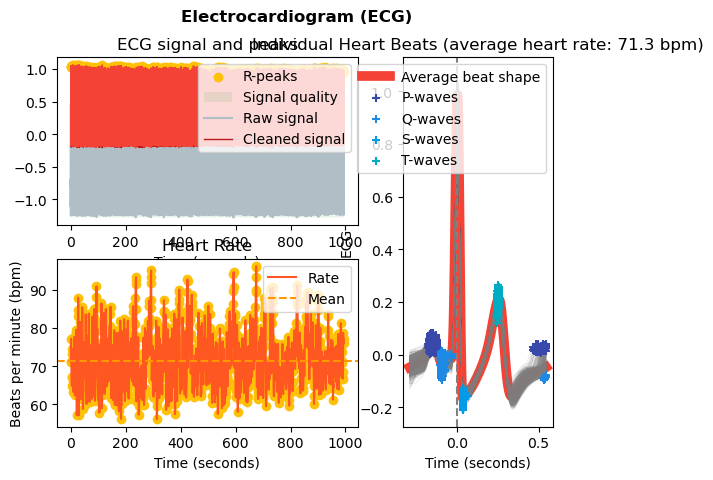

ECG analyze output of segment PB4.nf2_VR:
  ECG_Rate_Mean             HRV_MeanNN               HRV_SDNN  \
0     71.267955  [[842.4325699745547]]  [[85.54865070699192]]   

               HRV_SDANN1             HRV_SDNNI1              HRV_SDANN2  \
0  [[16.067780045420623]]  [[83.15233208290984]]  [[10.619284952912196]]   

              HRV_SDNNI2             HRV_SDANN5             HRV_SDNNI5  \
0  [[85.98964804484442]]  [[7.513717381107931]]  [[87.32212730477795]]   

               HRV_RMSSD  ...             HRV_SampEn            HRV_ShanEn  \
0  [[64.43975615390605]]  ...  [[1.455330353712474]]  [[8.16495435776012]]   

              HRV_FuzzyEn                HRV_MSEn               HRV_CMSEn  \
0  [[1.1894331314931108]]  [[1.1502352488836072]]  [[1.3760945455712787]]   

               HRV_RCMSEn                  HRV_CD                 HRV_HFD  \
0  [[2.1782572130235964]]  [[1.8155332236700714]]  [[1.8365009296719437]]   

                HRV_KFD                HRV_LZC  
0  [[4.10

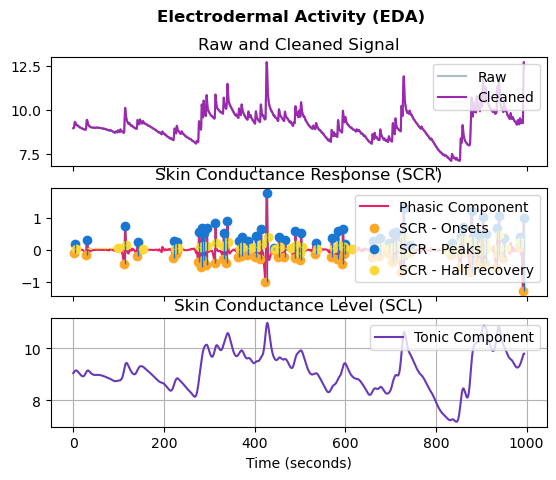

EDA of segment PB4.nf2_VR:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         53.0                  0.835829       0.76366         0.040599   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.008691             0.842803  

For file PB4:
segment: [baseline] before: [None] after [stress1_ABBA] start [57700] end [351394]
segment: [stress1_ABBA] before: [baseline] after [nf1_2D] start [351394] end [629301]
1972504
segment: [nf1_2D] before: [stress1_ABBA] after [stress2_MIST] start [1071782] end [2283824] marker_inside label[nf1_2D_unlimited] marker_inside index [1972504]
segment: [stress2_MIST] before: [nf1_2D] after [nf2_VR] start [2810013] end [3109227]
4509476
segment: [nf2_VR] before: [stress2_MIST] after [None] start [3610172] end [4604696] marker_inside label[nf2_VR_unlimited] marker_inside index [4509476]

File PB5:
Segment PB5.baseline:


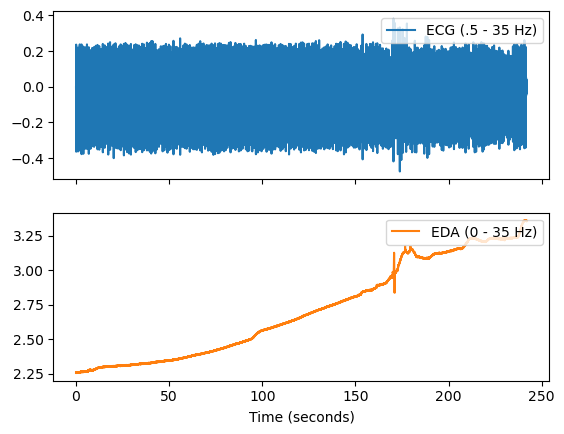

ECG of segment PB5.baseline:


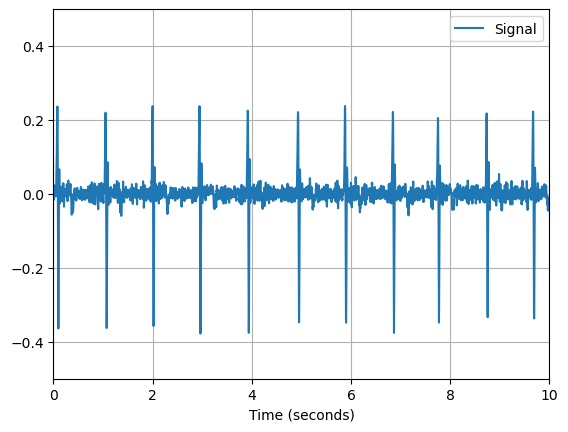

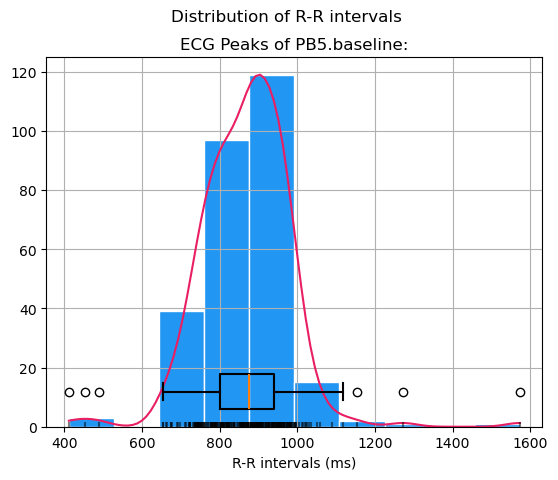

HRV of segment PB5.baseline:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  867.920578  112.193677   31.178223  106.970486         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN  110.488048  110.686078  ...      140.0   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     1.015437        780.2        952.6  33.935018  70.036101      412.0   

   HRV_MaxNN    HRV_HTI  HRV_TINN  
0     1573.0  21.307692     500.0  

[1 rows x 25 columns]
0    867.920578
Name: HRV_MeanNN, dtype: float64
0    112.193677
Name: HRV_SDNN, dtype: float64
0    110.488048
Name: HRV_RMSSD, dtype: float64


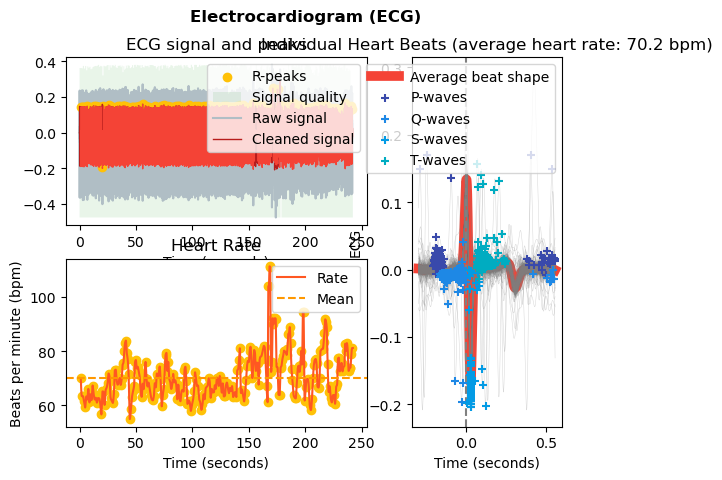

ECG analyze output of segment PB5.baseline:
  ECG_Rate_Mean             HRV_MeanNN              HRV_SDNN  \
0      70.18674  [[855.5658362989324]]  [[96.9193890381602]]   

               HRV_SDANN1             HRV_SDNNI1 HRV_SDANN2 HRV_SDNNI2  \
0  [[47.908554943889825]]  [[86.14587475579069]]    [[nan]]    [[nan]]   

  HRV_SDANN5 HRV_SDNNI5              HRV_RMSSD  ...              HRV_SampEn  \
0    [[nan]]    [[nan]]  [[65.75454900070196]]  ...  [[1.5074680515141348]]   

              HRV_ShanEn            HRV_FuzzyEn                HRV_MSEn  \
0  [[7.444698428661763]]  [[1.009717373376038]]  [[1.6647652952593572]]   

                HRV_CMSEn              HRV_RCMSEn                  HRV_CD  \
0  [[1.3422896657903522]]  [[1.9599212893825737]]  [[1.6582261615143736]]   

                  HRV_HFD                HRV_KFD                 HRV_LZC  
0  [[1.7112413338645243]]  [[2.544649267654414]]  [[0.7526515456432175]]  

[1 rows x 92 columns]
0    855.565836
Name: HRV_MeanNN, dtype:

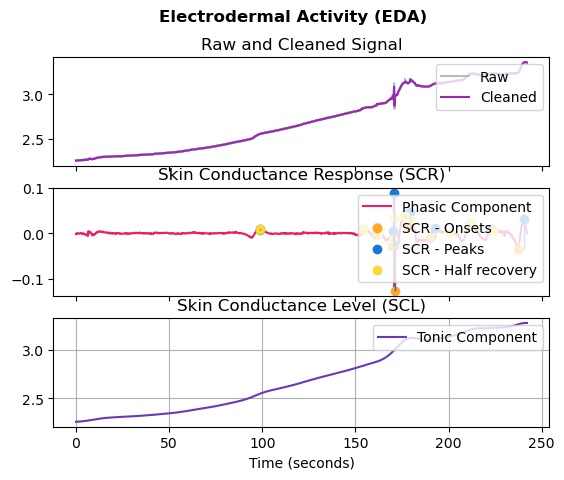

EDA of segment PB5.baseline:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         12.0                  0.033952      0.344005          0.00006   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000058             0.955245  
Segment PB5.stress1_MIST:


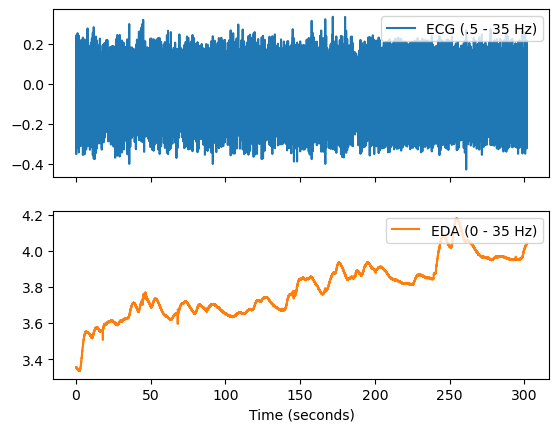

ECG of segment PB5.stress1_MIST:


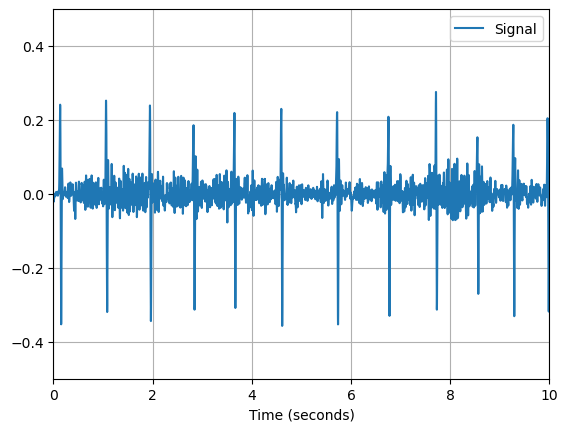

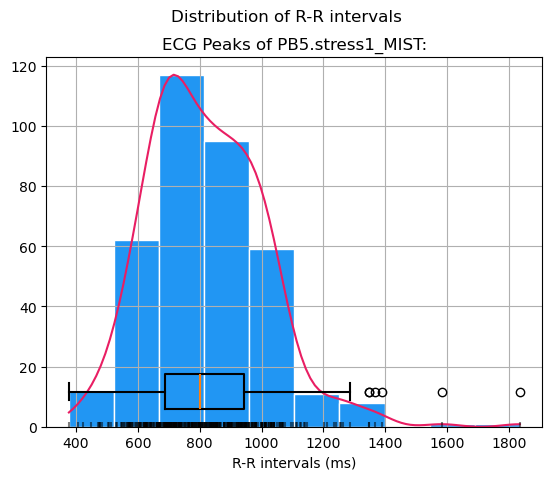

HRV of segment PB5.stress1_MIST:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0   821.23224  191.417919   49.730496  186.547678   19.347756  188.013341   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN  220.362447  220.664567  ...     254.75   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0      0.86865        667.0        977.0  53.551913   77.04918      377.0   

   HRV_MaxNN  HRV_HTI  HRV_TINN  
0     1835.0     30.5  367.1875  

[1 rows x 25 columns]
0    821.23224
Name: HRV_MeanNN, dtype: float64
0    191.417919
Name: HRV_SDNN, dtype: float64
0    220.362447
Name: HRV_RMSSD, dtype: float64


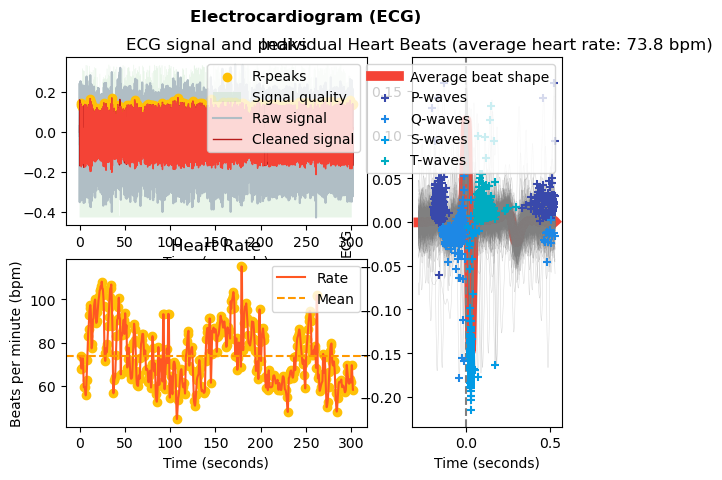

ECG analyze output of segment PB5.stress1_MIST:
  ECG_Rate_Mean            HRV_MeanNN                HRV_SDNN  \
0     73.799539  [[814.550135501355]]  [[154.21721449275856]]   

              HRV_SDANN1             HRV_SDNNI1             HRV_SDANN2  \
0  [[73.21023654488586]]  [[140.5712366066754]]  [[41.60022826826531]]   

               HRV_SDNNI2 HRV_SDANN5 HRV_SDNNI5               HRV_RMSSD  ...  \
0  [[150.65740861443777]]    [[nan]]    [[nan]]  [[101.01776909986205]]  ...   

              HRV_SampEn             HRV_ShanEn             HRV_FuzzyEn  \
0  [[1.065474730468234]]  [[7.930788481657345]]  [[0.8889565419802701]]   

                HRV_MSEn               HRV_CMSEn             HRV_RCMSEn  \
0  [[1.352150542104762]]  [[1.2617516139128298]]  [[2.210662347365998]]   

                   HRV_CD                 HRV_HFD                HRV_KFD  \
0  [[1.5768902393788817]]  [[1.7180220489514972]]  [[3.034925751504245]]   

                  HRV_LZC  
0  [[0.6008520383673992]]  


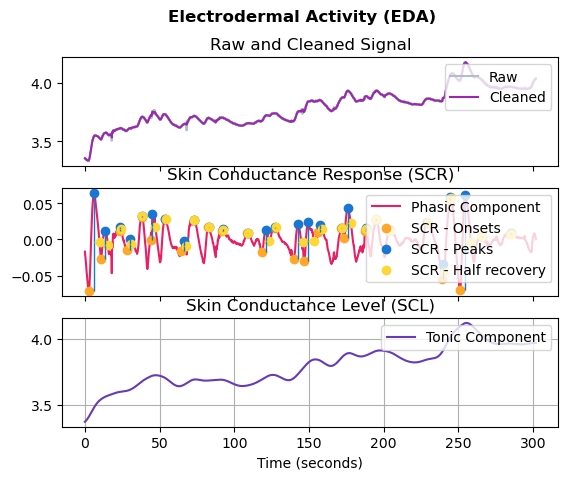

EDA of segment PB5.stress1_MIST:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         28.0                  0.021613      0.151306         0.000456   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000235             0.887571  
Segment PB5.nf1_2D:


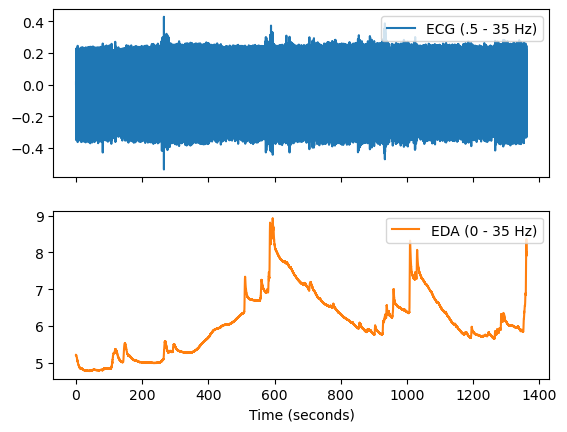

ECG of segment PB5.nf1_2D:


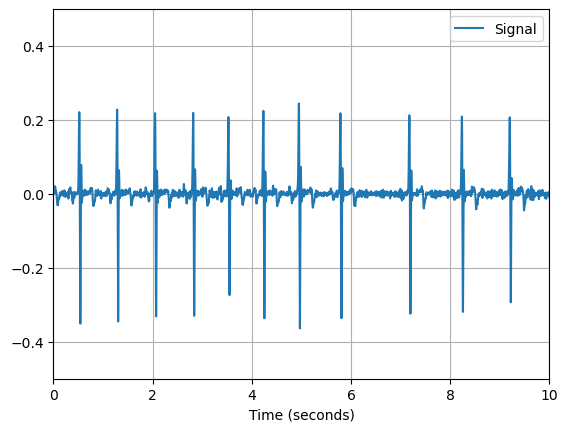

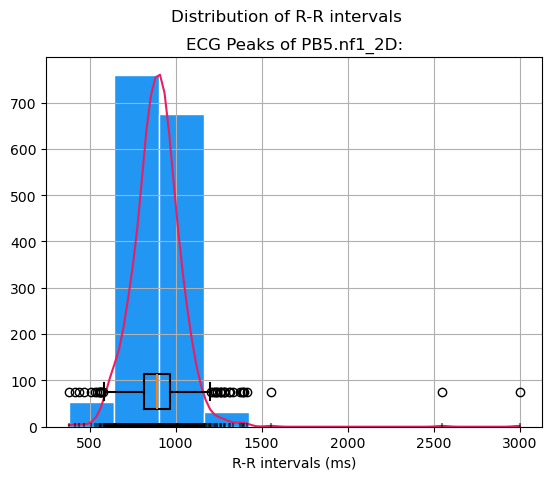

HRV of segment PB5.nf1_2D:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  893.246719  149.125609   48.391291  128.274652   37.122165  138.451553   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0   14.930819  141.704231  150.706622  150.756098  ...      155.5   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     0.989509        789.6        991.4   43.43832   71.91601      379.0   

   HRV_MaxNN    HRV_HTI  HRV_TINN  
0     3001.0  28.222222       0.0  

[1 rows x 25 columns]
0    893.246719
Name: HRV_MeanNN, dtype: float64
0    149.125609
Name: HRV_SDNN, dtype: float64
0    150.706622
Name: HRV_RMSSD, dtype: float64


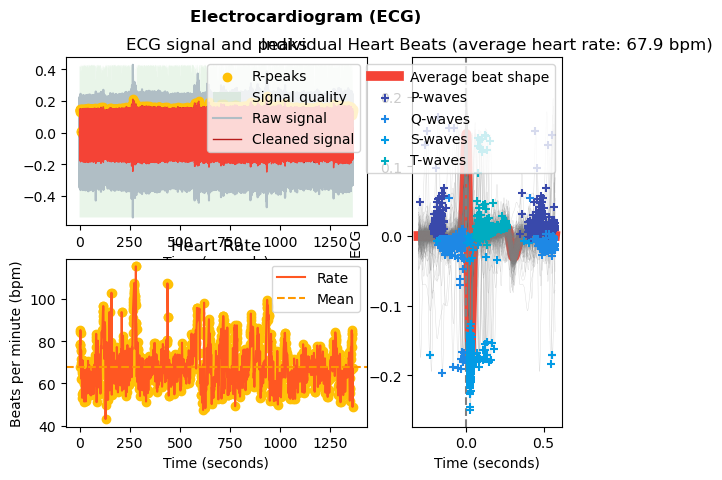

ECG analyze output of segment PB5.nf1_2D:
  ECG_Rate_Mean             HRV_MeanNN               HRV_SDNN  \
0     67.942358  [[883.9655844155844]]  [[125.3755040206426]]   

               HRV_SDANN1              HRV_SDNNI1              HRV_SDANN2  \
0  [[53.560145770902345]]  [[110.53559370326346]]  [[40.092794267671124]]   

               HRV_SDNNI2              HRV_SDANN5              HRV_SDNNI5  \
0  [[118.17268132329478]]  [[21.497893581140293]]  [[121.61900587824645]]   

               HRV_RMSSD  ...              HRV_SampEn             HRV_ShanEn  \
0  [[86.30901235696703]]  ...  [[1.3368871313036916]]  [[8.655099379058793]]   

              HRV_FuzzyEn               HRV_MSEn               HRV_CMSEn  \
0  [[0.9787072349999704]]  [[1.244565727712868]]  [[1.3690256841168276]]   

              HRV_RCMSEn                 HRV_CD                 HRV_HFD  \
0  [[2.094406908739902]]  [[1.617317466562167]]  [[1.7401356503652898]]   

                 HRV_KFD                 HRV_LZC  
0

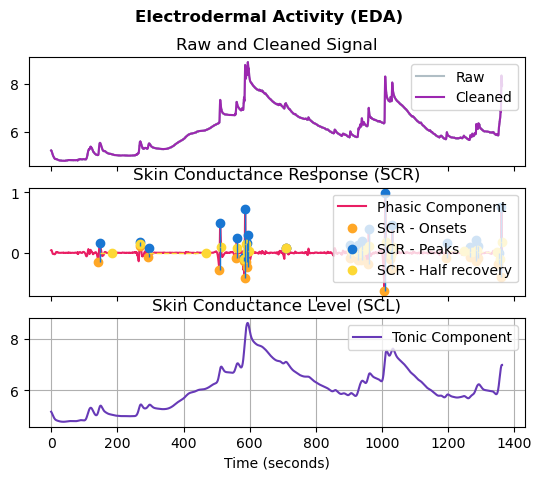

EDA of segment PB5.nf1_2D:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         23.0                  0.427327      0.829799         0.004496   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.003957             0.971277  
Segment PB5.stress2_ABBA:


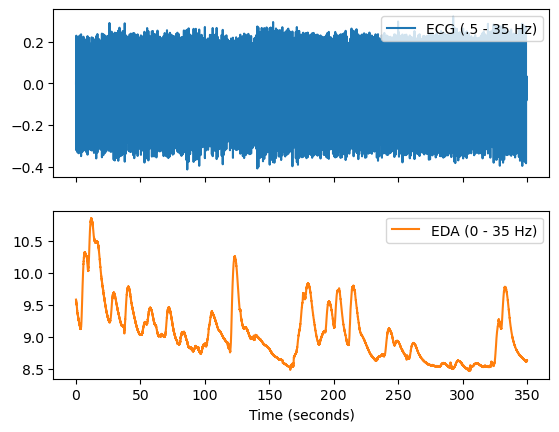

ECG of segment PB5.stress2_ABBA:


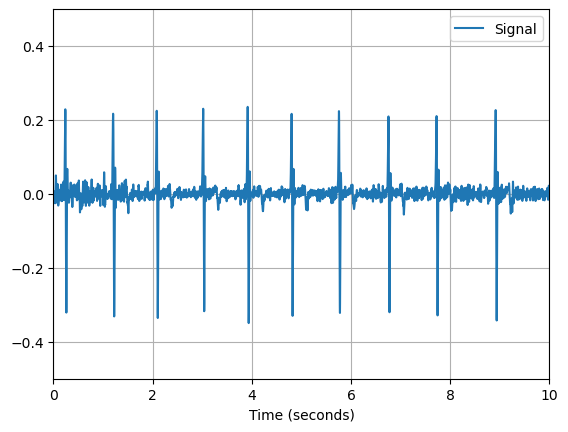

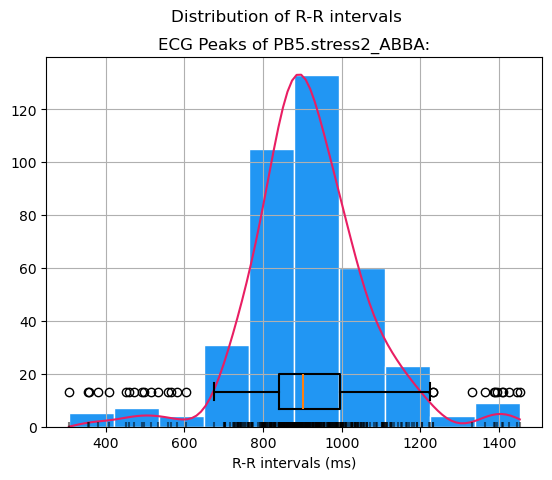

HRV of segment PB5.stress2_ABBA:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  913.349081  163.967203   37.845809  159.583494   27.544113  162.289596   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN  161.320643  161.533172  ...      155.0   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     1.016406        818.0       1017.0  47.506562  75.065617      306.0   

   HRV_MaxNN  HRV_HTI  HRV_TINN  
0     1453.0  23.8125   609.375  

[1 rows x 25 columns]
0    913.349081
Name: HRV_MeanNN, dtype: float64
0    163.967203
Name: HRV_SDNN, dtype: float64
0    161.320643
Name: HRV_RMSSD, dtype: float64


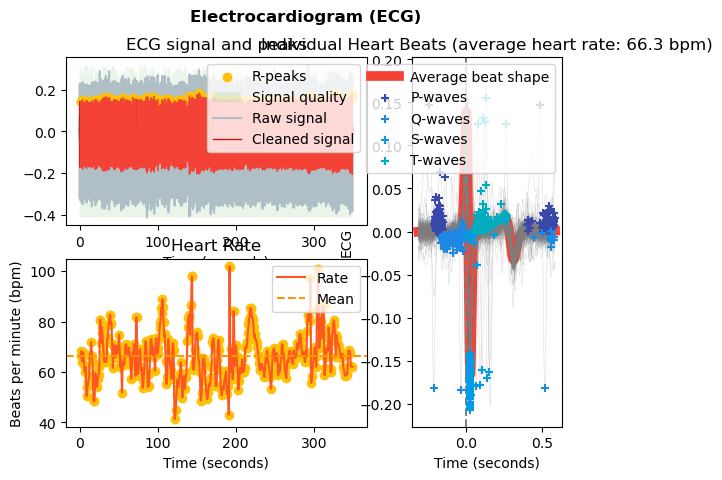

ECG analyze output of segment PB5.stress2_ABBA:
  ECG_Rate_Mean       HRV_MeanNN                HRV_SDNN  \
0     66.303049  [[906.2109375]]  [[128.69824153239753]]   

              HRV_SDANN1              HRV_SDNNI1              HRV_SDANN2  \
0  [[34.48880769315569]]  [[123.21983931280545]]  [[28.924258101610913]]   

               HRV_SDNNI2 HRV_SDANN5 HRV_SDNNI5               HRV_RMSSD  ...  \
0  [[124.23530194542748]]    [[nan]]    [[nan]]  [[103.79857225960846]]  ...   

               HRV_SampEn             HRV_ShanEn           HRV_FuzzyEn  \
0  [[1.3532998389848518]]  [[7.818319102509464]]  [[1.01827419657598]]   

                 HRV_MSEn               HRV_CMSEn            HRV_RCMSEn  \
0  [[1.6310149512832497]]  [[1.3189852442445373]]  [[2.01098718337013]]   

                   HRV_CD                HRV_HFD                HRV_KFD  \
0  [[1.5647520038326062]]  [[1.717693585114252]]  [[2.713869864849144]]   

                  HRV_LZC  
0  [[0.8719102539794924]]  

[1 rows x

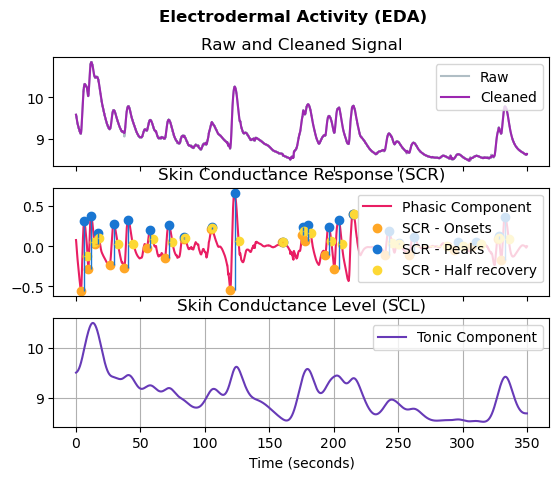

EDA of segment PB5.stress2_ABBA:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         23.0                  0.314092      0.411645         0.027951   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.001759             0.735979  
Segment PB5.nf2_VR:


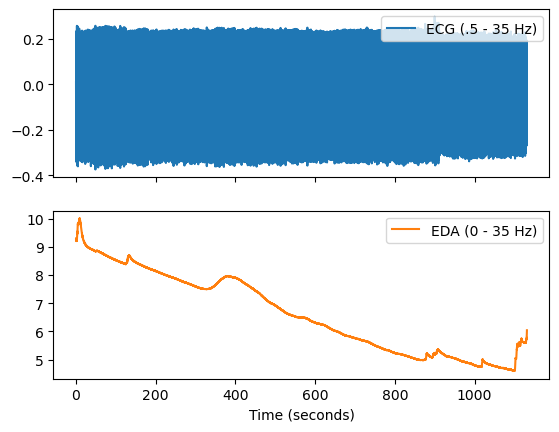

ECG of segment PB5.nf2_VR:


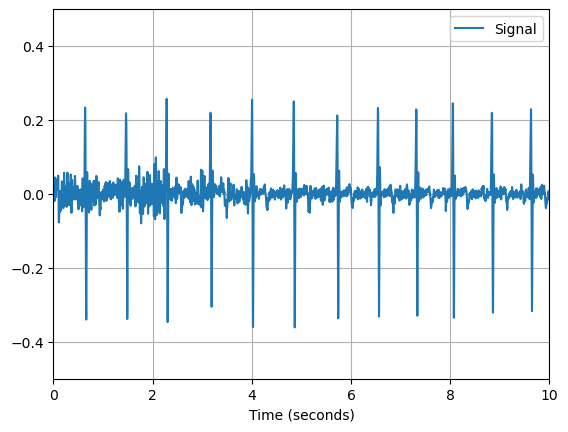

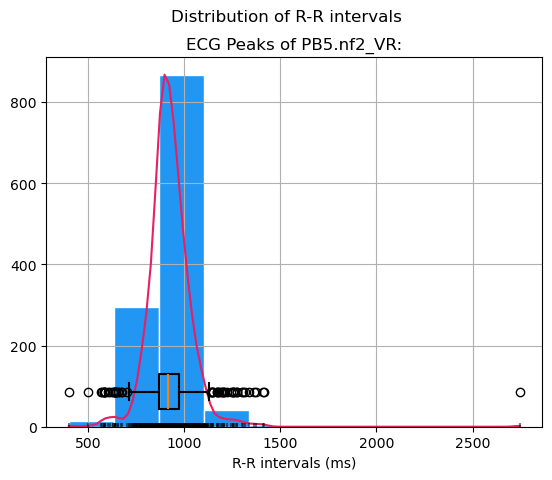

HRV of segment PB5.nf2_VR:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  924.569092  114.948497   37.873041   91.642274   24.867732   95.960952   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0   33.669085  107.961776  109.608487  109.65336  ...      105.0     1.048719   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        858.4        992.0  33.442355  68.438267      400.0     2746.0   

    HRV_HTI  HRV_TINN  
0  20.04918       0.0  

[1 rows x 25 columns]
0    924.569092
Name: HRV_MeanNN, dtype: float64
0    114.948497
Name: HRV_SDNN, dtype: float64
0    109.608487
Name: HRV_RMSSD, dtype: float64


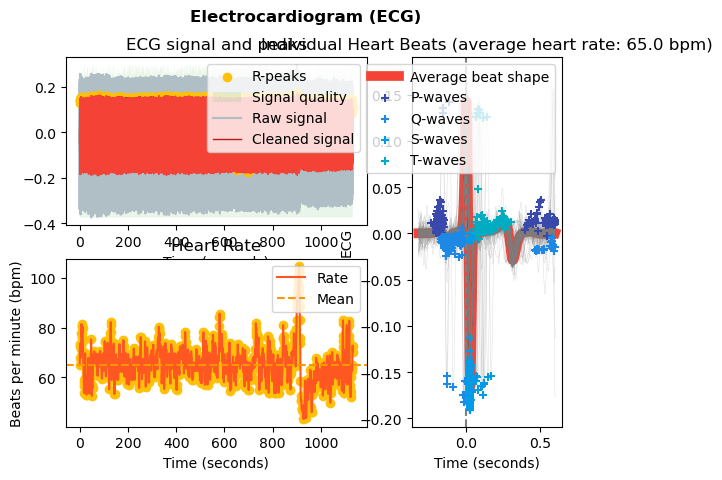

ECG analyze output of segment PB5.nf2_VR:
  ECG_Rate_Mean             HRV_MeanNN                HRV_SDNN  \
0      64.97666  [[923.8112745098039]]  [[100.26695114418926]]   

              HRV_SDANN1             HRV_SDNNI1             HRV_SDANN2  \
0  [[35.67408035915089]]  [[84.26662038084255]]  [[27.23460681859538]]   

              HRV_SDNNI2              HRV_SDANN5            HRV_SDNNI5  \
0  [[87.70192906507829]]  [[31.328488200217766]]  [[96.0763823157878]]   

                HRV_RMSSD  ...             HRV_SampEn            HRV_ShanEn  \
0  [[60.481800915877166]]  ...  [[1.381340438615988]]  [[8.18620758577639]]   

              HRV_FuzzyEn                HRV_MSEn               HRV_CMSEn  \
0  [[0.9828326431740845]]  [[0.9965621632871571]]  [[1.4246068433096932]]   

             HRV_RCMSEn                  HRV_CD                 HRV_HFD  \
0  [[1.88140551491498]]  [[1.4798977606113757]]  [[1.7297112567976998]]   

                  HRV_KFD                HRV_LZC  
0  [[2.7950

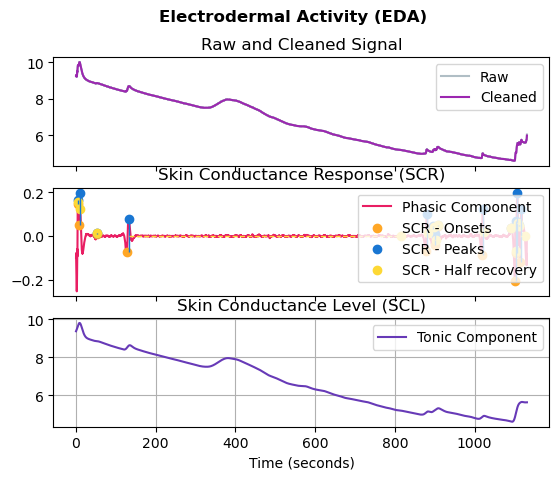

EDA of segment PB5.nf2_VR:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         14.0                  0.111888      1.415754         0.000253   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000074             0.991567  

For file PB5:
segment: [baseline] before: [None] after [stress1_MIST] start [414405] end [656492]
segment: [stress1_MIST] before: [baseline] after [nf1_2D] start [656492] end [958288]
2255175
segment: [nf1_2D] before: [stress1_MIST] after [stress2_ABBA] start [1312184] end [2674686] marker_inside label[nf1_2D_unlimited] marker_inside index [2255175]
segment: [stress2_ABBA] before: [nf1_2D] after [nf2_VR] start [3757071] end [4106989]
5611674
segment: [nf2_VR] before: [stress2_ABBA] after [None] start [4710946] end [5842463] marker_inside label[nf2_VR_unlimited] marker_inside index [5611674]

File PB7:
Segment PB7.baseline:


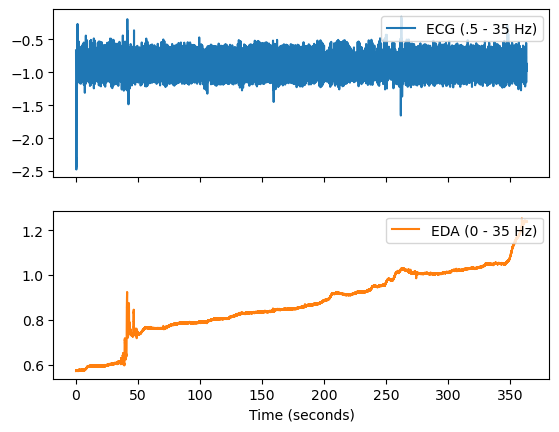

ECG of segment PB7.baseline:


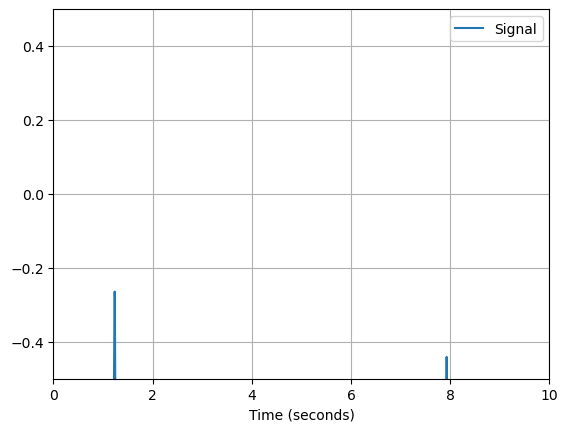

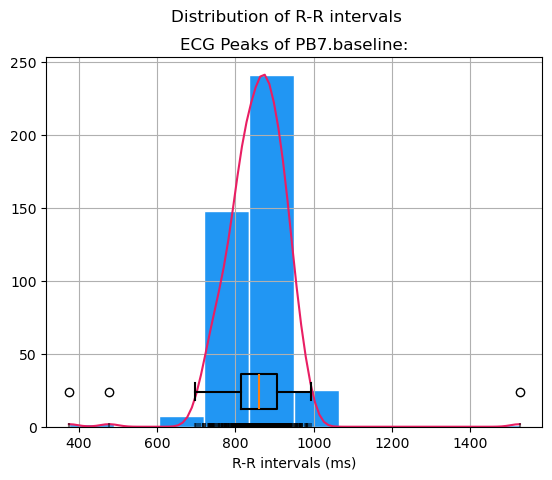

HRV of segment PB7.baseline:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  855.686321  77.094018   41.170094   62.979973   32.017228   71.170935   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN  62.810101  62.884476  ...      90.25     1.227414   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        799.0        914.0   5.896226  28.773585      374.0     1527.0   

     HRV_HTI  HRV_TINN  
0  15.703704   453.125  

[1 rows x 25 columns]
0    855.686321
Name: HRV_MeanNN, dtype: float64
0    77.094018
Name: HRV_SDNN, dtype: float64
0    62.810101
Name: HRV_RMSSD, dtype: float64


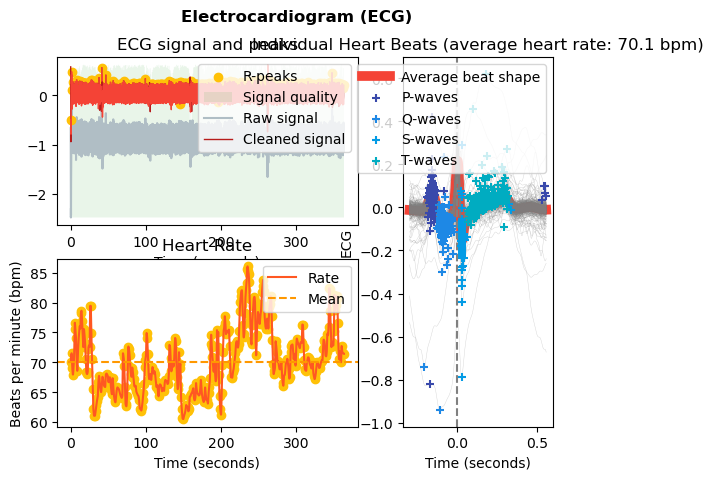

ECG analyze output of segment PB7.baseline:
  ECG_Rate_Mean            HRV_MeanNN               HRV_SDNN  \
0     70.125804  [[855.686320754717]]  [[63.40282265942838]]   

              HRV_SDANN1             HRV_SDNNI1             HRV_SDANN2  \
0  [[41.17810012582639]]  [[50.59992428714677]]  [[32.01794562435982]]   

              HRV_SDNNI2 HRV_SDANN5 HRV_SDNNI5               HRV_RMSSD  ...  \
0  [[57.30530296649641]]    [[nan]]    [[nan]]  [[22.619423022533983]]  ...   

               HRV_SampEn             HRV_ShanEn             HRV_FuzzyEn  \
0  [[0.8835775344678527]]  [[7.471434747286312]]  [[0.6670456701677918]]   

                HRV_MSEn               HRV_CMSEn             HRV_RCMSEn  \
0  [[1.461199706361833]]  [[1.2551547059006483]]  [[2.021109416683864]]   

                   HRV_CD                 HRV_HFD                 HRV_KFD  \
0  [[1.5524859912873439]]  [[1.5804362684669322]]  [[2.6974650380637177]]   

                  HRV_LZC  
0  [[0.5557873874368074]]  

[1 

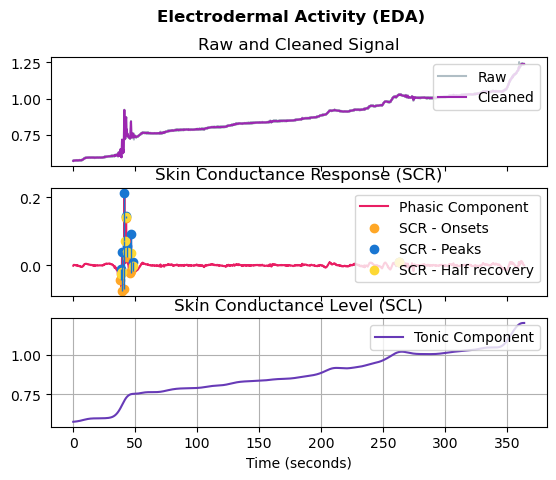

EDA of segment PB7.baseline:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0          8.0                  0.076475      0.143508         0.000053   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.001638             0.930982  
Segment PB7.stress1_ABBA:


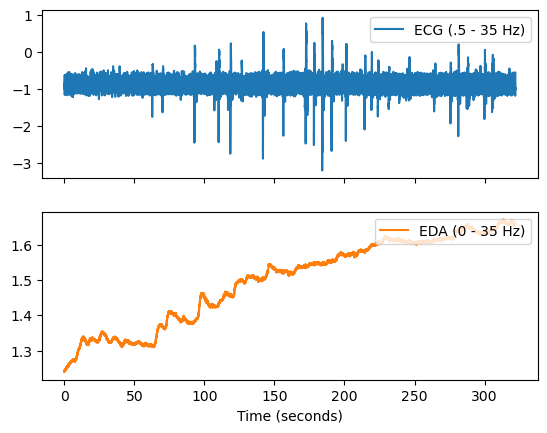

ECG of segment PB7.stress1_ABBA:


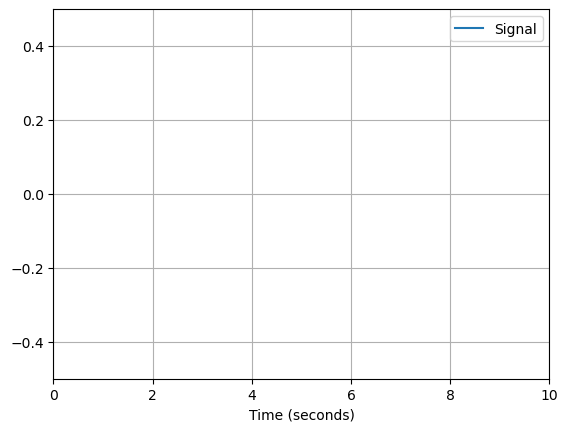

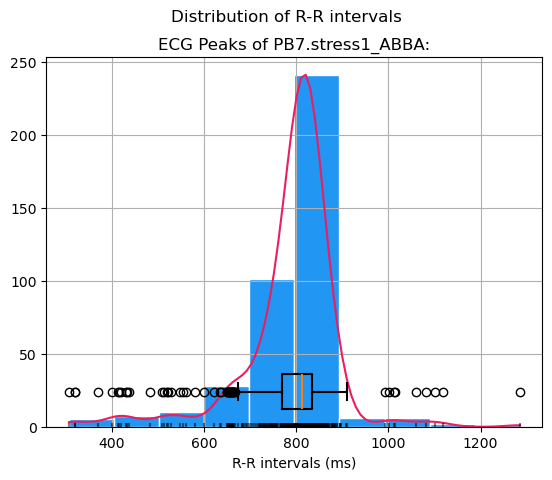

HRV of segment PB7.stress1_ABBA:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  788.253071  104.92506   29.723004  100.036269    12.11616  102.000627   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN  124.600534  124.754264  ...       65.0   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     0.842092        749.2        841.6  14.987715  36.363636      307.0   

   HRV_MaxNN   HRV_HTI  HRV_TINN  
0     1285.0  9.926829       0.0  

[1 rows x 25 columns]
0    788.253071
Name: HRV_MeanNN, dtype: float64
0    104.92506
Name: HRV_SDNN, dtype: float64
0    124.600534
Name: HRV_RMSSD, dtype: float64


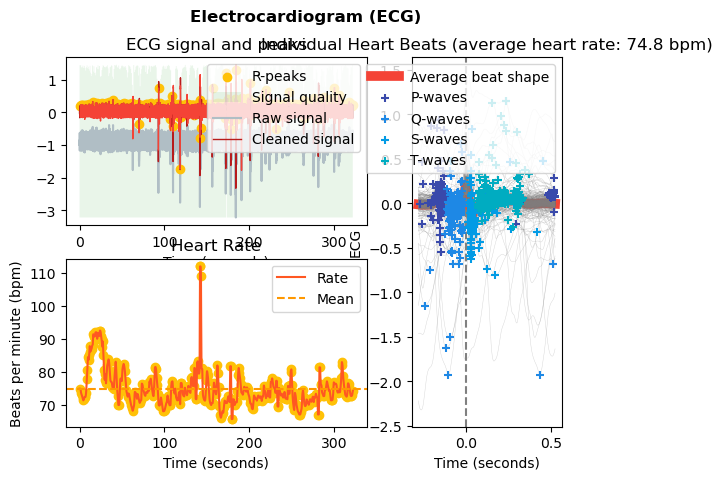

ECG analyze output of segment PB7.stress1_ABBA:
  ECG_Rate_Mean    HRV_MeanNN               HRV_SDNN             HRV_SDANN1  \
0      74.82123  [[802.0475]]  [[57.14884267680533]]  [[33.89424880937905]]   

              HRV_SDNNI1             HRV_SDANN2             HRV_SDNNI2  \
0  [[46.78344686325098]]  [[19.29289731891679]]  [[52.12930797244504]]   

  HRV_SDANN5 HRV_SDNNI5               HRV_RMSSD  ...              HRV_SampEn  \
0    [[nan]]    [[nan]]  [[29.607118293310567]]  ...  [[0.9335775478732011]]   

              HRV_ShanEn             HRV_FuzzyEn               HRV_MSEn  \
0  [[7.039525147083922]]  [[0.7556497674370237]]  [[1.405646590996491]]   

                HRV_CMSEn              HRV_RCMSEn                  HRV_CD  \
0  [[1.3386561759400604]]  [[1.7301010046554273]]  [[1.3065149100516174]]   

                  HRV_HFD                HRV_KFD                HRV_LZC  
0  [[1.6285075592044054]]  [[2.158789338779946]]  [[0.583460292809794]]  

[1 rows x 92 columns]
0    8

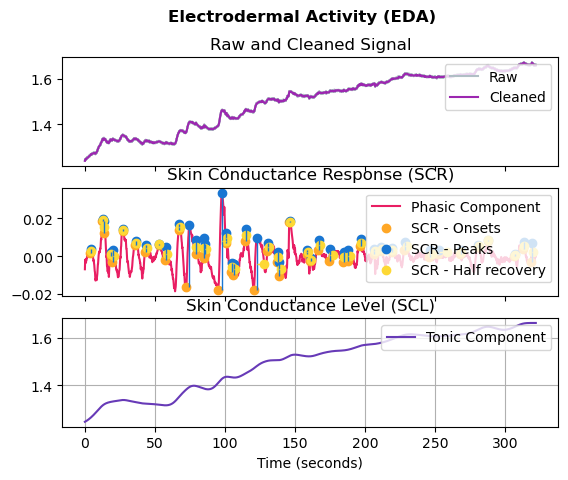

EDA of segment PB7.stress1_ABBA:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         44.0                  0.006342      0.119912         0.000061   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000246              0.95423  
Segment PB7.nf1_VR:


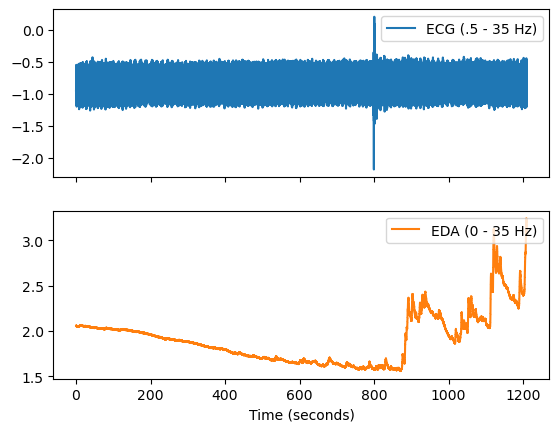

ECG of segment PB7.nf1_VR:


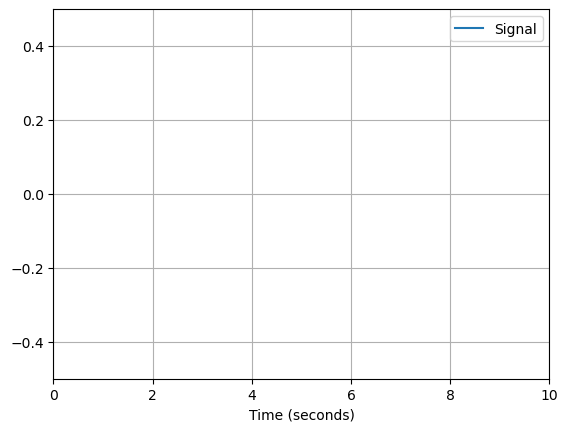

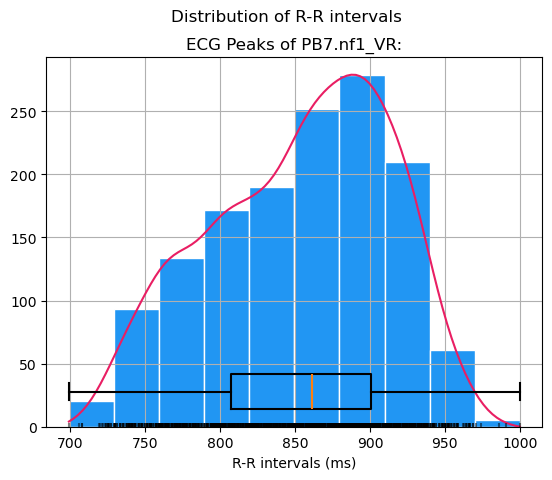

HRV of segment PB7.nf1_VR:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  853.526836  59.924823   10.858812   59.177597    9.797009   59.189298   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0    5.369105   59.794711  29.957249  29.967838  ...       94.0     2.000345   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        796.0        909.0   9.392655  50.070621      699.0     1000.0   

     HRV_HTI  HRV_TINN  
0  16.857143   265.625  

[1 rows x 25 columns]
0    853.526836
Name: HRV_MeanNN, dtype: float64
0    59.924823
Name: HRV_SDNN, dtype: float64
0    29.957249
Name: HRV_RMSSD, dtype: float64


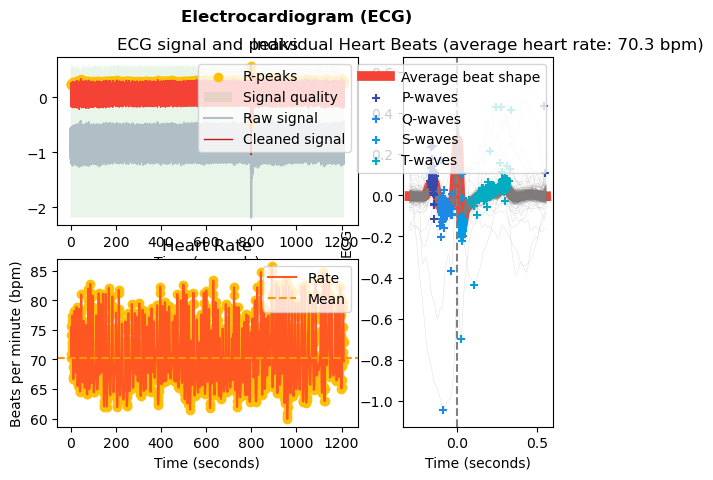

ECG analyze output of segment PB7.nf1_VR:
  ECG_Rate_Mean            HRV_MeanNN                HRV_SDNN  \
0     70.305256  [[853.526836158192]]  [[59.983537083167796]]   

               HRV_SDANN1             HRV_SDNNI1             HRV_SDANN2  \
0  [[10.859439743187082]]  [[59.23935498718239]]  [[9.796050115097135]]   

              HRV_SDNNI2             HRV_SDANN5              HRV_SDNNI5  \
0  [[59.24897448873243]]  [[5.368791133235192]]  [[59.853629519103535]]   

               HRV_RMSSD  ...              HRV_SampEn             HRV_ShanEn  \
0  [[29.95155098422157]]  ...  [[0.8252035491386338]]  [[7.702557436227506]]   

              HRV_FuzzyEn                HRV_MSEn               HRV_CMSEn  \
0  [[0.8308338689843099]]  [[0.9463579708675723]]  [[1.3505445922027228]]   

              HRV_RCMSEn                 HRV_CD                 HRV_HFD  \
0  [[2.214989632314131]]  [[1.612395425218661]]  [[1.4980345211824593]]   

                  HRV_KFD                 HRV_LZC  
0  [[3

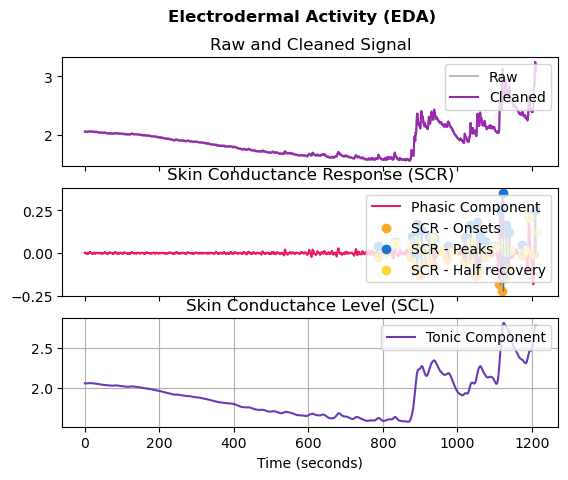

EDA of segment PB7.nf1_VR:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         26.0                  0.156726      0.271894         0.001254   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.005478             0.930949  
Segment PB7.stress2_MIST:


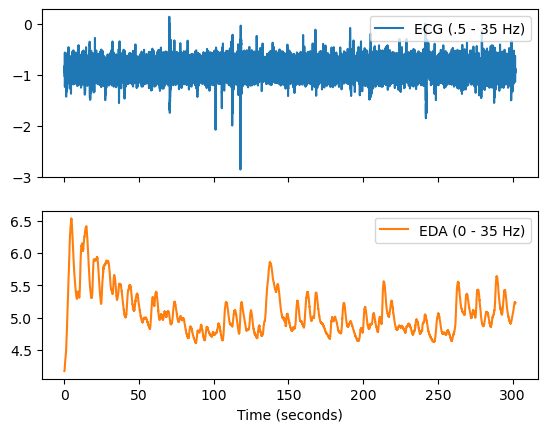

ECG of segment PB7.stress2_MIST:


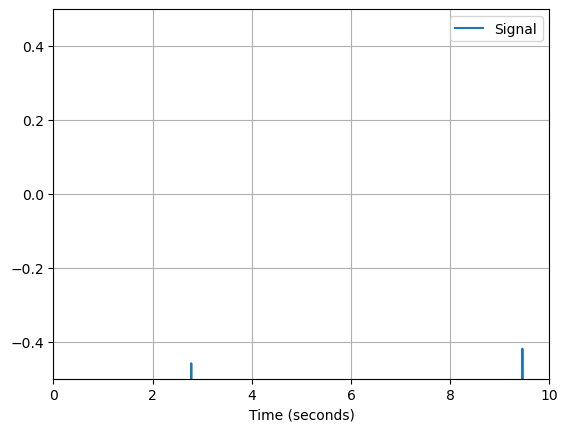

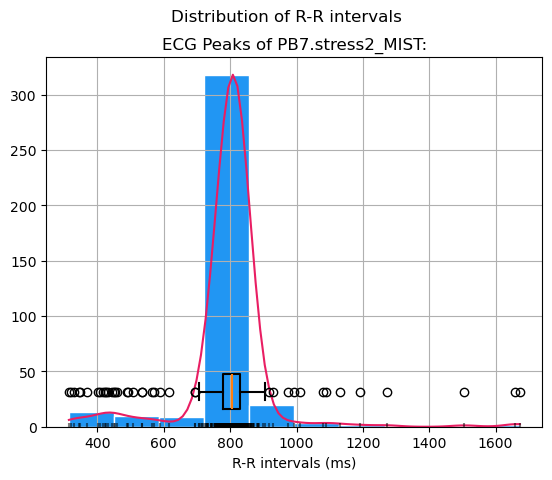

HRV of segment PB7.stress2_MIST:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  795.226913  130.776421   11.615157  126.479711   11.093882  136.284319   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN  164.264305  164.481977  ...       54.0   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     0.796134        769.0        837.0  16.622691  35.883905      314.0   

   HRV_MaxNN   HRV_HTI  HRV_TINN  
0     1673.0  9.973684       0.0  

[1 rows x 25 columns]
0    795.226913
Name: HRV_MeanNN, dtype: float64
0    130.776421
Name: HRV_SDNN, dtype: float64
0    164.264305
Name: HRV_RMSSD, dtype: float64


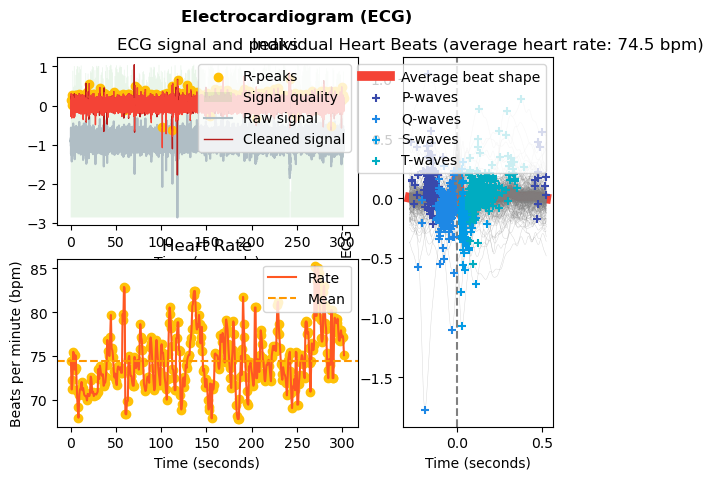

ECG analyze output of segment PB7.stress2_MIST:
  ECG_Rate_Mean            HRV_MeanNN               HRV_SDNN  \
0     74.460564  [[805.855614973262]]  [[35.70305756646038]]   

             HRV_SDANN1             HRV_SDNNI1              HRV_SDANN2  \
0  [[14.0413583944865]]  [[33.16384586235403]]  [[15.656516659519083]]   

               HRV_SDNNI2 HRV_SDANN5 HRV_SDNNI5               HRV_RMSSD  ...  \
0  [[34.587299641134315]]    [[nan]]    [[nan]]  [[22.361519034092122]]  ...   

               HRV_SampEn             HRV_ShanEn             HRV_FuzzyEn  \
0  [[1.2029132416747754]]  [[6.767981406307058]]  [[0.9641351818975435]]   

                 HRV_MSEn              HRV_CMSEn              HRV_RCMSEn  \
0  [[1.4175941076976595]]  [[1.432380759973294]]  [[2.1380371949825223]]   

                   HRV_CD                HRV_HFD                 HRV_KFD  \
0  [[1.6252186261687607]]  [[1.659389574495137]]  [[2.6513517394329895]]   

                  HRV_LZC  
0  [[0.7312850874770171]] 

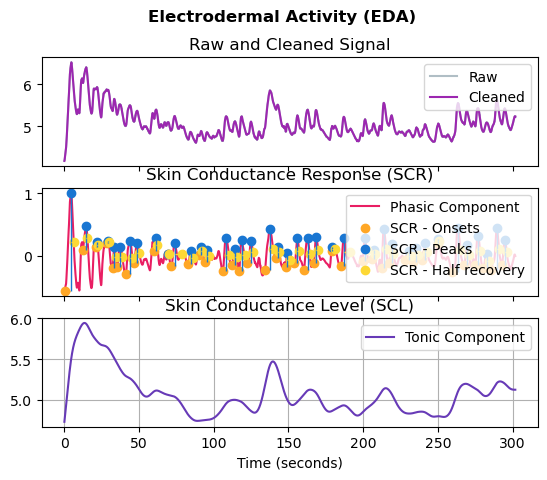

EDA of segment PB7.stress2_MIST:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         40.0                  0.350992      0.274353         0.020833   

   EDA_SympatheticN  EDA_Autocorrelation  
0           0.00396             0.466779  
Segment PB7.nf2_2D:


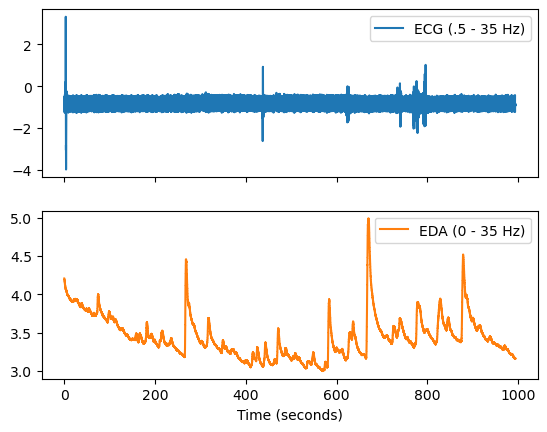

ECG of segment PB7.nf2_2D:


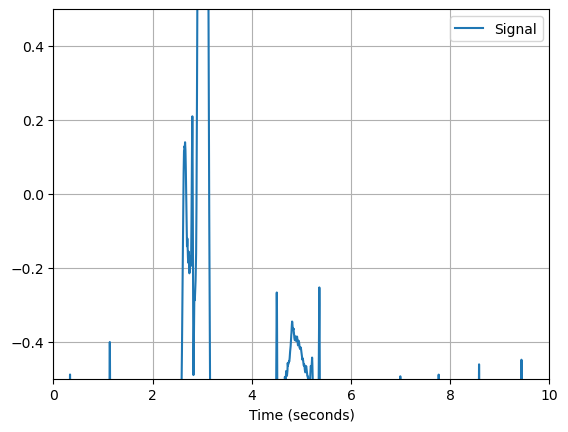

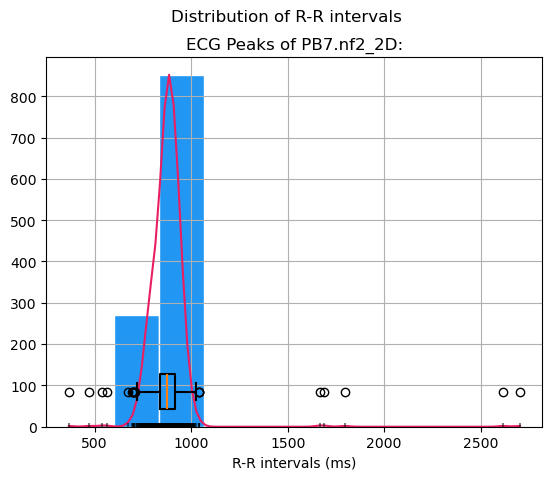

HRV of segment PB7.nf2_2D:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  877.064488  108.009473   24.755086   84.960751    18.96612    87.58363   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0   13.237157   98.367194  134.016003  134.075276  ...       78.0   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     0.805945        820.0        924.0  11.660777  40.989399      366.0   

   HRV_MaxNN    HRV_HTI  HRV_TINN  
0     2703.0  14.329114       0.0  

[1 rows x 25 columns]
0    877.064488
Name: HRV_MeanNN, dtype: float64
0    108.009473
Name: HRV_SDNN, dtype: float64
0    134.016003
Name: HRV_RMSSD, dtype: float64


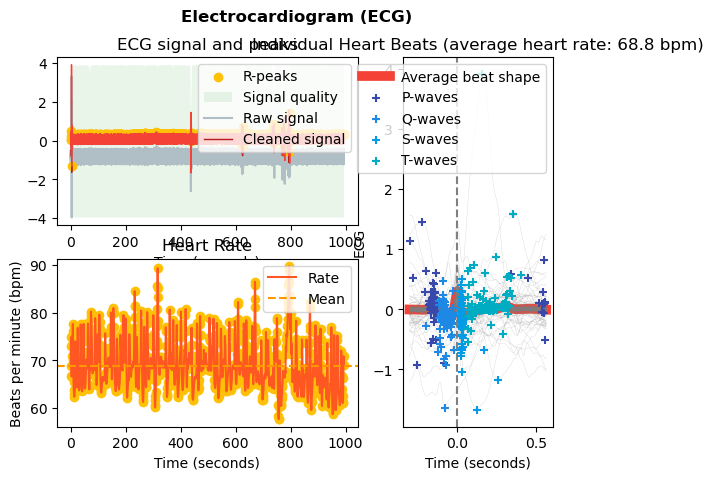

ECG analyze output of segment PB7.nf2_2D:
  ECG_Rate_Mean             HRV_MeanNN               HRV_SDNN  \
0      68.78219  [[872.4402460456942]]  [[60.90383755530643]]   

              HRV_SDANN1             HRV_SDNNI1              HRV_SDANN2  \
0  [[22.04400935375748]]  [[57.58486490185829]]  [[12.648847736396473]]   

             HRV_SDNNI2             HRV_SDANN5             HRV_SDNNI5  \
0  [[58.7674266495467]]  [[6.435990166818007]]  [[58.53671226609877]]   

               HRV_RMSSD  ...              HRV_SampEn             HRV_ShanEn  \
0  [[29.71319959935245]]  ...  [[0.7697083339173135]]  [[7.694079419579556]]   

              HRV_FuzzyEn                HRV_MSEn               HRV_CMSEn  \
0  [[0.7819785541675227]]  [[0.8818470717157908]]  [[1.4442259109146929]]   

            HRV_RCMSEn                  HRV_CD                HRV_HFD  \
0  [[2.0044354446635]]  [[1.4585173099791304]]  [[1.513958139118136]]   

                  HRV_KFD                 HRV_LZC  
0  [[2.9409372

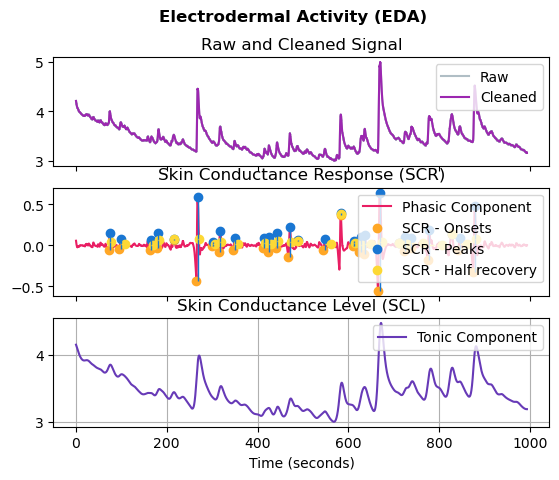

EDA of segment PB7.nf2_2D:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         27.0                   0.23859      0.258778          0.00843   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.007392             0.789036  

For file PB7:
segment: [baseline] before: [None] after [stress1_ABBA] start [0] end [363814]
segment: [stress1_ABBA] before: [baseline] after [nf1_VR] start [363814] end [685774]
2004233
segment: [nf1_VR] before: [stress1_ABBA] after [stress2_MIST] start [1104058] end [2314284] marker_inside label[nf1_VR_unlimited] marker_inside index [2004233]
segment: [stress2_MIST] before: [nf1_VR] after [nf2_2D] start [3295782] end [3597646]
4682751
segment: [nf2_2D] before: [stress2_MIST] after [None] start [3782942] end [4776764] marker_inside label[nf2_2D_unlimited] marker_inside index [4682751]

File PB12-partie 2:


AttributeError: 'Segment' object has no attribute 'df'

In [8]:
main()